# Intro<br>
Detect anomalies by applying isolation forest on clustered data. Based on the type of clustering, run the code section within Isolation forest section describing clustering method. <br>

<u>Sections</u>
<ol>
    <li>Feature engineering: making and choosing the feature columns</li>
    <li>Isolation Forest</li>
    <ol>
    <li><b>For each K_cluster:</b> Only K means clustering applied to data (cluster_22_clustered data)</li>
    <li><b>For each manual and K_cluster:</b> After clustering manually based on unique combinations of transaction type with account type, K means was applied on the small clusters (cluster_21_clustered)</li>
        <ul>
        <li>cluster_21_clustered_separate: One-hot encoded Dr_Cr and GL_AccType_AccountTypeDesc columns are separate</li>
        <li>cluster_21_clustered_merged: One-hot encoded Dr_Cr and GL_AccType_AccountTypeDesc columns merged together eg Dr_AccType</li>
        </ul>
    <li><b>Whole Population:</b> No clustering was applied to data</li>
    </ol>
    <li>Grading: Evaluating results based on risk factors to identify plausible true hits</li>
    <li>Explaining results: Explain feature importance using SHAP and LIME. Based on the cluster group/method, run either:<br> 1 group (K means cluster only or Manual clusters only)<br>or<br> 2 groups (Manual + K means)</li>

</ol>

# Import libraries and data

In [78]:
# Step 1: Import Libraries
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV, train_test_split, ParameterGrid
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score, make_scorer
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import shap

In [79]:
%reload_ext autoreload
%autoreload 2

import sys
from importlib import reload
import pandas as pd

# sys.path.append(r"E:\enyutan\Document\2025 MJE Advanced Analytics\Ishi")
import _00_util_sql
reload(_00_util_sql)
from _00_util_sql import Conn_ODBC

In [ ]:
sql_db=Conn_ODBC(database="JE_ML_2025")

##### Import data 
conn=sql_db.odbc_conn_db_pyodbc()
sql_query=f"SELECT * FROM [cluster_22_clustered]"
# sql_query=f"SELECT * FROM [cluster_21_clustered_merged]"
# sql_query=f"SELECT * FROM [cluster_21_clustered_separate]"
data_22=sql_db.odbc_run_sql(conn, sql_query, return_result=True)
conn.close()

data_22.info()
# 1 mins

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156740 entries, 0 to 156739
Data columns (total 80 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   FiscalYear                                  156740 non-null  int64         
 1   AccDocNo                                    156740 non-null  int64         
 2   Dr_Cr                                       156740 non-null  object        
 3   DateOfAccDocEntry                           156740 non-null  object        
 4   DateOfAccDocEntry_and_TimeOfEntry (MYT)     156740 non-null  datetime64[ns]
 5   NoOfLineItemInAccDoc                        156740 non-null  object        
 6   GL_DESCRIPTION                              156740 non-null  object        
 7   Amt_localCurrencyFormatted                  156740 non-null  object        
 8   Document Type Description                   156740 non-null  object       

In [108]:
siewdf = pd.read_csv(rf"D:\victoriaquek\JE ML 2025\Results\data_p_ishi_GL_JE_cleaned_SIEWPL", index_col=0)
# siewdf.info()

data_22 = siewdf.loc[:, siewdf.notna().any()]
data_22.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18992 entries, 0 to 18991
Data columns (total 63 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   FiscalYear                                  18992 non-null  int64  
 1   AccDocNo                                    18992 non-null  int64  
 2   Dr_Cr                                       18992 non-null  object 
 3   DateOfAccDocEntry                           18992 non-null  object 
 4   DateOfAccDocEntry_and_TimeOfEntry (MYT)     18992 non-null  object 
 5   NoOfLineItemInAccDoc                        18992 non-null  object 
 6   RefKeyForLineItem                           18992 non-null  object 
 7   GL_DESCRIPTION                              18992 non-null  object 
 8   Amt_localCurrencyFormatted                  18992 non-null  object 
 9   Document Type Description                   18992 non-null  object 
 10  Quantity       

# Feature engineering


In [122]:
features = [
'GL_DESCRIPTION',
'Amt_localCurrencyFormatted',
'Document Type Description',
'Username',
'DocHeaderText',
'IsDocReversalOrReversedDoc',
'PostingKey',
'isLineItemAutomaticallyCreated',
'TermsOfPayment',
'CashDiscountAmountInLocalCurrency',
'PaymentMethod',
'Plant',
'WBSElement',
'GL_AccType_AccountTypeDesc',
'Username Type',
'Amt_DocCurrency_NoOfTrailingZeroes',
'CashDiscountPercentage',
# 'IND_MonthEnd',
# 'IND_QuarterEnd',
# 'IND_YearEnd',
# 'IND_Weekend',
# 'IND_PublicHol',
# 'IND_OutsideWorkHours',
# 'SpecialGLIndicator',
# 'hasSubsequentDrCrMemo',
# 'IdOfLineItem',
# 'TransactionCode',
# 'Quantity',

# New features from ZOTC
# 'Carrier Key Desc'
]

In [123]:
encoded_cols = [col for col in data_22.columns if col.startswith('labelled_')]
print(len(encoded_cols))
encoded_cols

15


['labelled_GL_AccType',
 'labelled_AccountTypeDesc',
 'labelled_GL_AccType_AccountTypeDesc',
 'labelled_GL_DESCRIPTION',
 'labelled_Document Type Description',
 'labelled_Username',
 'labelled_TransactionCode',
 'labelled_IdOfLineItem',
 'labelled_PostingKey',
 'labelled_isLineItemAutomaticallyCreated',
 'labelled_TermsOfPayment',
 'labelled_PaymentMethod',
 'labelled_FollowOnDocType',
 'labelled_Plant',
 'labelled_Username Type']

In [124]:
encoded_cols.remove('labelled_GL_AccType')
encoded_cols.remove('labelled_AccountTypeDesc')
encoded_cols

['labelled_GL_AccType_AccountTypeDesc',
 'labelled_GL_DESCRIPTION',
 'labelled_Document Type Description',
 'labelled_Username',
 'labelled_TransactionCode',
 'labelled_IdOfLineItem',
 'labelled_PostingKey',
 'labelled_isLineItemAutomaticallyCreated',
 'labelled_TermsOfPayment',
 'labelled_PaymentMethod',
 'labelled_FollowOnDocType',
 'labelled_Plant',
 'labelled_Username Type']

## Making new Revenue

In [125]:
amounts = [
'Cr_Asset - Asset',
'Cr_Asset - Customer', 
'Cr_Asset - G\\L Account', 
'Cr_Asset - Material',
'Cr_Cost of Goods Sold (COGS) - G\\L Account',
'Cr_Expense (6) - G\\L Account',
'Cr_Liability - G\\L Account', 
'Cr_Liability - Vendor',
'Cr_Other Costs - G\\L Account', 
'Cr_Other Revenue - G\\L Account', 
'Cr_Revenue - G\\L Account', 
'Dr_Asset - Asset', 
'Dr_Asset - Customer', 
'Dr_Asset - G\\L Account', 
'Dr_Asset - Material', 
'Dr_Cost of Goods Sold (COGS) - G\\L Account', 
'Dr_Expense (6) - G\\L Account', 
'Dr_Liability - G\\L Account', 
'Dr_Liability - Vendor', 
'Dr_Other Costs - G\\L Account', 
'Dr_Other Revenue - G\\L Account', 
'Dr_Revenue - G\\L Account'
]

In [126]:
# List to store matches
revenue_list = []

# String to search for
search_term = "revenue"

# Case-insensitive search and add matches to new list
for s in amounts:
    if search_term.lower() in s.lower():
        revenue_list.append(s)

revenue_list

['Cr_Other Revenue - G\\L Account',
 'Cr_Revenue - G\\L Account',
 'Dr_Other Revenue - G\\L Account',
 'Dr_Revenue - G\\L Account']

In [127]:
def calculate_revenue(row, revenue_list):
    total = 0
    for col in revenue_list:
        if col.startswith('Cr_'):
            total -= row[col]
        elif col.startswith('Dr_'):
            total -= row[col]
    return total

# Apply function row-wise
data_22['Revenue'] = data_22.apply(calculate_revenue, axis=1, revenue_list=revenue_list)

In [128]:
# data_22.iloc[11]

## Mark if any 1

In [129]:
df_result = data_22.copy()

In [130]:
import ast
def has_positive_string(x):
        try:
            # Convert string to actual list
            values = ast.literal_eval(x) if isinstance(x, str) else x
            # Check if any string in the list represents a number > 0
            return int(any(float(val) > 0 for val in values))
        except Exception as e:
            return e

try:
    df_result['Amt_DocCurrency_NoOfTrailingZeroes_flag'] = df_result['Amt_DocCurrency_NoOfTrailingZeroes'].apply(lambda x: int(any(val > 0 for val in x)))
except Exception as e:
    df_result['Amt_DocCurrency_NoOfTrailingZeroes_flag'] = df_result['Amt_DocCurrency_NoOfTrailingZeroes'].apply(has_positive_string)

In [131]:
def mark_any_one(df, cols, new_col_name='has_one'):
    df[new_col_name] = df[cols].apply(lambda row: int(1 in row.values), axis=1)
    return df

merge_cols = ['IND_MonthEnd', 'IND_QuarterEnd', 'IND_YearEnd']
mark_any_one(df_result, merge_cols, new_col_name='EndCheck')

merge_cols = ['IND_Weekend', 'IND_PublicHol', 'IND_OutsideWorkHours']
mark_any_one(df_result, merge_cols, new_col_name='OtherCheck')

,FiscalYear,AccDocNo,Dr_Cr,DateOfAccDocEntry,DateOfAccDocEntry_and_TimeOfEntry (MYT),NoOfLineItemInAccDoc,RefKeyForLineItem,GL_DESCRIPTION,Amt_localCurrencyFormatted,Document Type Description,...,Dr_Asset - G\L Account,Dr_Cost of Goods Sold (COGS) - G\L Account,Dr_Liability - G\L Account,Dr_Other Costs - G\L Account,Dr_Other Revenue - G\L Account,Dr_Revenue - G\L Account,Revenue,Amt_DocCurrency_NoOfTrailingZeroes_flag,EndCheck,OtherCheck
0,2014,9900467949,"['Dr', 'Cr', 'Cr', 'Dr', 'Cr']",2014-01-08,2014-01-08 20:21:18,"['001', '002', '003', '004', '005']","['5821-MRT-PMO-004', None, None, None, None]","['Accounts Receivable Control Account', 'Third...","[3018.0, -2848.0, -284.0, 284.0, -170.0]",Billing Doc.Transfer,...,0.0,0.0,0.0,0.0,0.0,284.0,3018.0,1,0,1
1,2014,9900546273,"['Dr', 'Cr']",2014-01-05,2014-01-06 14:23:14,"['001', '002']","[8500008426, None]","['Accounts Receivable Control Account', 'Third...","[1280.0, -1280.0]",Billing Doc.Transfer,...,0.0,0.0,0.0,0.0,0.0,0.0,1280.0,1,0,0
2,2014,9900555709,"['Dr', 'Cr']",2014-01-06,2014-01-06 21:30:01,"['001', '002']","[8400061160, None]","['Accounts Receivable Control Account', 'Third...","[2128.0, -2128.0]",Billing Doc.Transfer,...,0.0,0.0,0.0,0.0,0.0,0.0,2128.0,0,0,1
3,2014,9900588004,"['Dr', 'Cr', 'Cr', 'Cr']",2014-01-10,2014-01-10 17:54:51,"['001', '002', '003', '004']","[13012154, None, None, None]","['Accounts Receivable Control Account', 'Third...","[201.0, -67.0, -67.0, -67.0]",Billing Doc.Transfer,...,0.0,0.0,0.0,0.0,0.0,0.0,201.0,0,0,0
4,2014,9900634699,"['Dr', 'Cr']",2014-01-02,2014-01-02 19:09:35,"['001', '002']","[626733, None]","['Accounts Receivable Control Account', 'Third...","[66.0, -66.0]",Billing Doc.Transfer,...,0.0,0.0,0.0,0.0,0.0,0.0,66.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18987,2019,9950788382,"['Cr', 'Dr']",2019-06-14,2019-06-14 16:15:56,"['001', '002']","['190240AUT', None]","['Accounts Receivable Control Account', 'Marke...","[-20.0, 20.0]",Bill Doc.Tr - Cr Mem,...,0.0,0.0,20.0,0.0,0.0,0.0,0.0,1,0,0
18988,2019,9950790111,"['Cr', 'Dr']",2019-06-18,2019-06-18 18:15:10,"['001', '002']","['180414HPB(R1)', None]","['Accounts Receivable Control Account', 'Vendo...","[-120.0, 120.0]",Bill Doc.Tr - Cr Mem,...,0.0,0.0,120.0,0.0,0.0,0.0,0.0,1,0,0
18989,2019,9950790176,"['Cr', 'Dr']",2019-06-18,2019-06-18 18:15:51,"['001', '002']","['180417HPW(R1)', None]","['Accounts Receivable Control Account', 'Vendo...","[-150.0, 150.0]",Bill Doc.Tr - Cr Mem,...,0.0,0.0,150.0,0.0,0.0,0.0,0.0,1,0,0
18990,2019,9950790623,"['Cr', 'Dr']",2019-06-18,2019-06-19 10:15:53,"['001', '002']","['180416HPD(R1)', None]","['Accounts Receivable Control Account', 'Vendo...","[-1700.0, 1700.0]",Bill Doc.Tr - Cr Mem,...,0.0,0.0,1700.0,0.0,0.0,0.0,0.0,1,0,0


In [132]:
cols = ['IND_Weekend', 'IND_PublicHol', 'IND_OutsideWorkHours','OtherCheck']
df_result[df_result[cols].eq(1).any(axis=1)][cols]

,IND_Weekend,IND_PublicHol,IND_OutsideWorkHours,OtherCheck
0,0,0,1,1
2,0,0,1,1
4,0,0,1,1
20,0,0,1,1
28,0,0,1,1
...,...,...,...,...
18940,1,0,0,1
18954,0,0,1,1
18966,0,0,1,1
18973,0,0,1,1


In [133]:
cols = ['IND_MonthEnd', 'IND_QuarterEnd', 'IND_YearEnd','EndCheck']
df_result[df_result[cols].eq(1).any(axis=1)][cols]

,IND_MonthEnd,IND_QuarterEnd,IND_YearEnd,EndCheck
412,0,0,1,1
447,0,0,1,1
547,0,0,1,1
585,1,0,0,1
588,0,0,1,1
...,...,...,...,...
18959,0,0,1,1
18960,0,1,1,1
18961,0,1,1,1
18975,1,0,0,1


## One Hot Encoding (1/0)

In [134]:
def expand_list_column_distinct_values(df, column_list):
    """
    For each column in column_list, extract distinct non-NULL values from list entries,
    and create binary indicator columns for each distinct value.
    
    Parameters:
    df (pd.DataFrame): Input dataframe
    column_list (list): List of column names to process
    
    Returns:
    pd.DataFrame: Original dataframe with new binary columns for each distinct value
    """
    # Make a copy to avoid modifying the original dataframe
    result_df = df.copy()
    
    for col in column_list:
        if col not in df.columns:
            print(f"Warning: Column '{col}' not found in dataframe.")
            continue
            
        # To store all distinct non-NULL values across all rows
        distinct_values = set()
        
        # First pass: collect all distinct non-NULL values
        for idx, row in df.iterrows():
            cell_value = row[col]
            
            # Handle cases where the cell might not be a list
            if isinstance(cell_value, (list, tuple)):
                # Filter out NULL/None/NaN values
                non_null_values = [val for val in cell_value 
                                 if val is not None and not (isinstance(val, float) and pd.isna(val))]
                distinct_values.update(non_null_values)
        
        # Sort for consistent column ordering
        distinct_values = sorted(distinct_values)
        
        # If no distinct values found (all NULL), still create columns with 0s
        if not distinct_values:
            distinct_values = []
        
        # Second pass: create binary indicator columns
        for value in distinct_values:
            new_col_name = f"{col}_{value}"
            indicator_values = []
            
            for idx, row in df.iterrows():
                cell_value = row[col]
                found = 0
                
                if isinstance(cell_value, (list, tuple)):
                    # Check if the value exists in the list (and list is not all NULL)
                    non_null_values = [val for val in cell_value 
                                     if val is not None and not (isinstance(val, float) and pd.isna(val))]
                    
                    if value in non_null_values:
                        found = 1
                    # If all values in list are NULL, keep 0 (already set)
                
                indicator_values.append(found)
            
            result_df[new_col_name] = indicator_values
    
    return result_df

In [135]:
one_cols = [
'Document Type Description',
'IsDocReversalOrReversedDoc',
'PostingKey',
'TermsOfPayment',
'Plant',
'isLineItemAutomaticallyCreated',
'PaymentMethod',
'Username Type']
df_result = expand_list_column_distinct_values(df_result, one_cols)

In [136]:
to_encode = [
'Document Type Description',
'IsDocReversalOrReversedDoc',
'Username Type']
encoder = OneHotEncoder(sparse_output=False)
encoded_array = encoder.fit_transform(df_result[to_encode])

# Convert to DataFrame
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(to_encode))

# Combine with original DataFrame
df_result = pd.concat([df_result, encoded_df], axis=1)

## Selecting feature cols

In [137]:
df_result.columns.tolist()

['FiscalYear',
 'AccDocNo',
 'Dr_Cr',
 'DateOfAccDocEntry',
 'DateOfAccDocEntry_and_TimeOfEntry (MYT)',
 'NoOfLineItemInAccDoc',
 'RefKeyForLineItem',
 'GL_DESCRIPTION',
 'Amt_localCurrencyFormatted',
 'Document Type Description',
 'Quantity',
 'Username',
 'TransactionCode',
 'IsDocReversalOrReversedDoc',
 'IdOfLineItem',
 'PostingKey',
 'isLineItemAutomaticallyCreated',
 'TermsOfPayment',
 'CashDiscountAmountInLocalCurrency',
 'PaymentMethod',
 'Plant',
 'hasSubsequentDrCrMemo',
 'WBSElement',
 'SpecialGLIndicator',
 'GL_AccType_AccountTypeDesc',
 'Username Type',
 'Amt_DocCurrency_NoOfTrailingZeroes',
 'CashDiscountPercentage',
 'IND_MonthEnd',
 'IND_QuarterEnd',
 'IND_YearEnd',
 'IND_Weekend',
 'IND_PublicHol',
 'IND_OutsideWorkHours',
 'labelled_GL_AccType',
 'labelled_AccountTypeDesc',
 'labelled_GL_AccType_AccountTypeDesc',
 'labelled_GL_DESCRIPTION',
 'labelled_Document Type Description',
 'labelled_Username',
 'labelled_TransactionCode',
 'labelled_IdOfLineItem',
 'labelled_Po

In [138]:
non_features = [
'Dr_Cr',
'FiscalYear', 
'AccDocNo', 
'DateOfAccDocEntry', 
'DateOfAccDocEntry_and_TimeOfEntry (MYT)',
'NoOfLineItemInAccDoc',
'Customer PO Number', 
'IS Rep',
'Sold-To Id',
'IND_MonthEnd',
'IND_QuarterEnd',
'IND_YearEnd',
'IND_Weekend',
'IND_PublicHol',
'IND_OutsideWorkHours',
'SpecialGLIndicator',
'hasSubsequentDrCrMemo',
'IdOfLineItem',
'TransactionCode',
'Quantity',
'labelled_TransactionCode',
'labelled_Document Type Description',
'labelled_Username Type',
'IsDocReversalOrReversedDoc',
]

# Get boolean cols
bool_cols = df_result.select_dtypes(include='bool').columns.tolist()
print(bool_cols)

# Convert bool cols to int
df_result[bool_cols] = df_result[bool_cols].astype(int)

# Get numerical feature columns
def get_num_cols(df):
    numerical_cols = df.select_dtypes(include='number').columns.tolist()

    numerical_cols = [item for item in numerical_cols if item not in non_features]

    return numerical_cols

num_cols = get_num_cols(df_result)
print(len(num_cols))
print(num_cols)

[]
26
['Cr_Asset - Customer', 'Cr_Asset - G\\L Account', 'Cr_Cost of Goods Sold (COGS) - G\\L Account', 'Cr_Liability - G\\L Account', 'Cr_Other Costs - G\\L Account', 'Cr_Other Revenue - G\\L Account', 'Cr_Revenue - G\\L Account', 'Dr_Asset - Customer', 'Dr_Asset - G\\L Account', 'Dr_Cost of Goods Sold (COGS) - G\\L Account', 'Dr_Liability - G\\L Account', 'Dr_Other Costs - G\\L Account', 'Dr_Other Revenue - G\\L Account', 'Dr_Revenue - G\\L Account', 'Revenue', 'Amt_DocCurrency_NoOfTrailingZeroes_flag', 'EndCheck', 'OtherCheck', 'Document Type Description_Bill Doc.Tr - Cr Mem', 'Document Type Description_Bill Doc.Tr - Dr Mem', 'Document Type Description_Billing Doc.Transfer', 'IsDocReversalOrReversedDoc_1.0', 'IsDocReversalOrReversedDoc_2.0', 'IsDocReversalOrReversedDoc_nan', 'Username Type_MY', 'Username Type_System']


In [139]:
df_numeric = df_result[num_cols].copy()
df_numeric.columns.tolist()

['Cr_Asset - Customer',
 'Cr_Asset - G\\L Account',
 'Cr_Cost of Goods Sold (COGS) - G\\L Account',
 'Cr_Liability - G\\L Account',
 'Cr_Other Costs - G\\L Account',
 'Cr_Other Revenue - G\\L Account',
 'Cr_Revenue - G\\L Account',
 'Dr_Asset - Customer',
 'Dr_Asset - G\\L Account',
 'Dr_Cost of Goods Sold (COGS) - G\\L Account',
 'Dr_Liability - G\\L Account',
 'Dr_Other Costs - G\\L Account',
 'Dr_Other Revenue - G\\L Account',
 'Dr_Revenue - G\\L Account',
 'Revenue',
 'Amt_DocCurrency_NoOfTrailingZeroes_flag',
 'EndCheck',
 'OtherCheck',
 'Document Type Description_Bill Doc.Tr - Cr Mem',
 'Document Type Description_Bill Doc.Tr - Dr Mem',
 'Document Type Description_Billing Doc.Transfer',
 'IsDocReversalOrReversedDoc_1.0',
 'IsDocReversalOrReversedDoc_2.0',
 'IsDocReversalOrReversedDoc_nan',
 'Username Type_MY',
 'Username Type_System']

In [140]:
# df_result['Document Type Description'].value_counts(dropna=False)

# Isolation forest

## Functions

In [25]:
def run_isolation_forest_by_group(input_df, group_col, contamination='auto', compute_shap=False):
    results = []
    models = {}  # To store trained models per group
    shap_explanations = {}  # To store SHAP values per group (if requested)
    input_df_filled = input_df.copy()

    # Loop over each group
    input_df_filled[group_col] = input_df_filled[group_col].fillna('NAN')  # or any placeholder
    for group_name, group_data in input_df_filled.groupby(group_col):  #, dropna=False
        # print(f"\nRunning Isolation Forest on cluster/group: {group_name}")
        
        # Keep original index for mapping back
        original_index = group_data.index

        # Extract feature matrix
        X_in = group_data.drop(columns=[group_col], errors='ignore')

        # Scale features (recommended for better performance)
        # scaler = StandardScaler()
        # X_scaled = scaler.fit_transform(X)

        # Train Isolation Forest
        iso_forest = IsolationForest(
            n_estimators=50,             # default = 100
            max_features=1.0,
            max_samples='auto',
            contamination=contamination,
            random_state=42,
        )

        # iso_forest.fit(X_scaled)
        iso_forest.fit(X_in)

        # Predict anomaly scores and labels
        anomaly_scores = iso_forest.score_samples(X_in)    # Returns the raw anomaly score (log of average path length).
        predictions = iso_forest.predict(X_in)  # -1 = anomaly, 1 = normal

        # Count anomalies in this group
        num_anomalies = sum(predictions == -1)
        print(f"Cluster {group_name}: {num_anomalies} anomalies")

        # Add predictions to group_data
        group_result = pd.DataFrame({
            'anomaly_score': anomaly_scores,
            'is_anomaly': (predictions==-1),
            # 'is_anomaly_flag': (predictions == -1)
        }, index=original_index)

        # Append processed group
        results.append(group_result)
        models[group_name] = iso_forest  # Save model

        # 🔍 Compute SHAP values if requested
        if compute_shap:
            # Use TreeExplainer on the Isolation Forest
            explainer = shap.TreeExplainer(
                iso_forest,
                # feature_perturbation="interventional",  # or "tree_path_dependent"
                feature_perturbation="auto",  # or "tree_path_dependent"
                model_output='raw'  # score_samples output
            )
            shap_values = explainer.shap_values(X_in)
            shap_explanations[group_name] = {
                'shap_values': shap_values,
                'data': X_in,
                'explainer': explainer
            }

    # Concatenate all processed groups back into one DataFrame
    final_df = pd.concat(results)

    # # Ensure we preserve original order using original index
    final_df = final_df.reindex(input_df.index)

    if compute_shap:
        return final_df, models, shap_explanations
    else:
        return final_df

In [161]:
def add_anomaly_columns_to_original_df(data_original, anomalies_df):
    """
    Adds only the new anomaly columns to the original DataFrame,
    skipping any that already exist.

    Parameters:
        data_original (pd.DataFrame): Original DataFrame (e.g., data_22)
        anomalies_df (pd.DataFrame): DataFrame with predicted anomaly results

    Returns:
        pd.DataFrame: Updated DataFrame with only the new anomaly columns added
    """
    # List of expected anomaly-related columns
    new_cols = ['anomaly_score', 'is_anomaly']

    # Check which columns are missing in data_original
    cols_to_add = [col for col in new_cols if col not in data_original.columns]

    if not cols_to_add:
        print("\n✅ All anomaly columns already exist. No new columns to add.")
        return data_original

    print(f"\n➕ Adding the following columns to the original DataFrame: {cols_to_add}")

    # Join only the missing columns
    data_with_anomalies = data_original.join(anomalies_df[cols_to_add])

    return data_with_anomalies

## For each K_cluster <br> 
Use data clustered using K Means algo

In [ ]:
df_numeric.info()

In [ ]:
if 'anomaly' in df_numeric:
    print('True')
    df_numeric = df_numeric.drop('anomaly', axis=1)
    print('Removed')

try:
    # Check for NaNs
    print("Number of NaN values:", np.isnan(df_numeric).sum().sum())

    # Check for Infs
    print("Number of Inf values:", np.isinf(df_numeric).sum().sum())

except:
    print("Number of NaN values:", df_numeric.isna().sum().sum())
    # Check for Infs
    # print("Number of Inf values:", df_numeric.isinf().sum().sum())

# Find columns with at least one NaN
nan_columns = df_numeric.columns[df_numeric.isna().any()].tolist()
# print("Columns with NaN values:", nan_columns)

# Get unique non-null values from each NaN column
unique_data_in_nan_columns = {
    col: df_numeric[col].dropna().unique().tolist()
    for col in nan_columns
}

# Display the results
for col, unique_vals in unique_data_in_nan_columns.items():
    print(f"Column: {col}")
    print(f"Unique values (excluding NaN): {unique_vals}\n")

exclude_col = 'K_cluster'

# Apply fillna with 0 to all except exclude_col 
cols_to_fill = [col for col in df_numeric.columns if col != exclude_col]
df_numeric[cols_to_fill] = df_numeric[cols_to_fill].fillna(0)

Number of NaN values: 0
Number of Inf values: 0


### Remove Cluster_ID when applying ML on only K_cluster

In [ ]:
print(df_numeric.columns.tolist())
df_num = df_numeric.drop('Cluster_ID', axis=1)
df_num.columns.tolist()

['Cr_Asset - Asset', 'Cr_Asset - Customer', 'Cr_Asset - G\\L Account', 'Cr_Asset - Material', 'Cr_Cost of Goods Sold (COGS) - G\\L Account', 'Cr_Expense (6) - G\\L Account', 'Cr_Liability - G\\L Account', 'Cr_Liability - Vendor', 'Cr_Other Costs - G\\L Account', 'Cr_Other Revenue - G\\L Account', 'Cr_Revenue - G\\L Account', 'Dr_Asset - Asset', 'Dr_Asset - Customer', 'Dr_Asset - G\\L Account', 'Dr_Asset - Material', 'Dr_Cost of Goods Sold (COGS) - G\\L Account', 'Dr_Expense (6) - G\\L Account', 'Dr_Liability - G\\L Account', 'Dr_Liability - Vendor', 'Dr_Other Costs - G\\L Account', 'Dr_Other Revenue - G\\L Account', 'Dr_Revenue - G\\L Account', 'Cluster_ID', 'K_cluster', 'Revenue', 'Amt_DocCurrency_NoOfTrailingZeroes_flag', 'EndCheck', 'OtherCheck', 'PostingKey_01', 'PostingKey_02', 'PostingKey_11', 'PostingKey_12', 'PostingKey_40', 'PostingKey_50', 'TermsOfPayment_NT03', 'TermsOfPayment_NT05', 'TermsOfPayment_NT07', 'TermsOfPayment_NT14', 'TermsOfPayment_NT30', 'TermsOfPayment_NT35', 

['Cr_Asset - Asset',
 'Cr_Asset - Customer',
 'Cr_Asset - G\\L Account',
 'Cr_Asset - Material',
 'Cr_Cost of Goods Sold (COGS) - G\\L Account',
 'Cr_Expense (6) - G\\L Account',
 'Cr_Liability - G\\L Account',
 'Cr_Liability - Vendor',
 'Cr_Other Costs - G\\L Account',
 'Cr_Other Revenue - G\\L Account',
 'Cr_Revenue - G\\L Account',
 'Dr_Asset - Asset',
 'Dr_Asset - Customer',
 'Dr_Asset - G\\L Account',
 'Dr_Asset - Material',
 'Dr_Cost of Goods Sold (COGS) - G\\L Account',
 'Dr_Expense (6) - G\\L Account',
 'Dr_Liability - G\\L Account',
 'Dr_Liability - Vendor',
 'Dr_Other Costs - G\\L Account',
 'Dr_Other Revenue - G\\L Account',
 'Dr_Revenue - G\\L Account',
 'K_cluster',
 'Revenue',
 'Amt_DocCurrency_NoOfTrailingZeroes_flag',
 'EndCheck',
 'OtherCheck',
 'PostingKey_01',
 'PostingKey_02',
 'PostingKey_11',
 'PostingKey_12',
 'PostingKey_40',
 'PostingKey_50',
 'TermsOfPayment_NT03',
 'TermsOfPayment_NT05',
 'TermsOfPayment_NT07',
 'TermsOfPayment_NT14',
 'TermsOfPayment_NT30',


In [ ]:
# Check for NaNs
print("Number of NaN values:", np.isnan(df_num).sum().sum())

# Check for Infs
print("Number of Inf values:", np.isinf(df_num).sum().sum())

# Find columns with at least one NaN
nan_columns = df_num.columns[df_num.isna().any()].tolist()
# print("Columns with NaN values:", nan_columns)

# Get unique non-null values from each NaN column
unique_data_in_nan_columns = {
    col: df_numeric[col].dropna().unique().tolist()
    for col in nan_columns
}

# Display the results
for col, unique_vals in unique_data_in_nan_columns.items():
    print(f"Column: {col}")
    print(f"Unique values (excluding NaN): {unique_vals}\n")

Number of NaN values: 0
Number of Inf values: 0


In [ ]:
exclude_col = 'K_cluster'

# Apply fillna with 0 to all except column 'B'
cols_to_fill = [col for col in df_num.columns if col != exclude_col]
df_num[cols_to_fill] = df_num[cols_to_fill].fillna(0)

if 'anomaly' in df_num:
    print('True')
    df_numeric = df_num.drop('anomaly', axis=1)
    print('Removed')
 
# Check for NaNs
print("Number of NaN values:", np.isnan(df_num).sum().sum())

# Check for Infs
print("Number of Inf values:", np.isinf(df_num).sum().sum())

Number of NaN values: 0
Number of Inf values: 0


In [ ]:
df_with_anomalies = run_isolation_forest_by_group(df_num, group_col='K_cluster', contamination=0.01)

Cluster 0: 1015 anomalies
Cluster 1: 204 anomalies
Cluster 2: 199 anomalies
Cluster 3: 94 anomalies
Cluster 4: 54 anomalies


In [ ]:
df_with_anomalies[df_with_anomalies['is_anomaly'] == 1]

,anomaly_score,is_anomaly
617,-0.647392,True
633,-0.686255,True
1133,-0.672039,True
1385,-0.661013,True
1410,-0.683785,True
...,...,...
153080,-0.583289,True
153089,-0.583289,True
153434,-0.695566,True
153444,-0.699341,True


In [ ]:
# Add only the missing anomaly columns to original data_22
data_22_with_anomalies = add_anomaly_columns_to_original_df(data_22, df_with_anomalies)


➕ Adding the following columns to the original DataFrame: ['anomaly_score', 'is_anomaly']


In [ ]:
data_22_with_anomalies.info()
# data_22_with_anomalies.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156740 entries, 0 to 156739
Data columns (total 83 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   FiscalYear                                  156740 non-null  int64         
 1   AccDocNo                                    156740 non-null  int64         
 2   Dr_Cr                                       156740 non-null  object        
 3   DateOfAccDocEntry                           156740 non-null  object        
 4   DateOfAccDocEntry_and_TimeOfEntry (MYT)     156740 non-null  datetime64[ns]
 5   NoOfLineItemInAccDoc                        156740 non-null  object        
 6   GL_DESCRIPTION                              156740 non-null  object        
 7   Amt_localCurrencyFormatted                  156740 non-null  object        
 8   Document Type Description                   156740 non-null  object       

In [ ]:
table_name="anomaly_res_21m"
try:
    sql_db.fn_create_new_table_from_df(table_name=table_name, df=data_22_with_anomalies.head(5), auto_data_type=True)
    res=sql_db.fn_append_df_to_table(table_name=table_name, df=data_22_with_anomalies.head(5))
    print(res)
except Exception as e:
    print(e)
    data_22_with_anomalies.to_csv(rF'd:\victoriaquek\JE ML 2025\{table_name}')
    # data_22_with_anomalies.to_excel(rf"D:\victoriaquek\JE ML 2025\{table_name}.xlsx")
# 9 mins

(pyodbc.Error) ('HY104', '[HY104] [Microsoft][ODBC SQL Server Driver]Invalid precision value (0) (SQLBindParameter)')
[SQL: SELECT [INFORMATION_SCHEMA].[TABLES].[TABLE_NAME] 
FROM [INFORMATION_SCHEMA].[TABLES] 
WHERE ([INFORMATION_SCHEMA].[TABLES].[TABLE_TYPE] = CAST(? AS NVARCHAR(max)) OR [INFORMATION_SCHEMA].[TABLES].[TABLE_TYPE] = CAST(? AS NVARCHAR(max))) AND [INFORMATION_SCHEMA].[TABLES].[TABLE_NAME] = CAST(? AS NVARCHAR(max)) AND [INFORMATION_SCHEMA].[TABLES].[TABLE_SCHEMA] = CAST(? AS NVARCHAR(max))]
[parameters: ('BASE TABLE', 'VIEW', 'anomaly_res_21m', 'dbo')]
(Background on this error at: https://sqlalche.me/e/20/dbapi)


## For each manual and K_cluster

In [ ]:
df_manual = df_numeric[df_numeric['K_cluster'].isna()]
df_k_means = df_numeric[df_numeric['K_cluster'].notna()]
df_k_means.info()

In [ ]:
# if 'anomaly' in df_numeric:
#     print('anomaly found')
#     df_numeric = df_numeric.drop('anomaly', axis=1)
#     print('Removed')

# Cleaning df_manual feature df (data from biggest 9 manual clusters)

# Apply fillna with 0 to all except column exclude_col
exclude_col = 'K_cluster'

cols_to_fill = [col for col in df_manual.columns if col != exclude_col]
df_manual[cols_to_fill] = df_manual[cols_to_fill].fillna(0)

# Remove K_cluster from manual feature df
if 'K_cluster' in df_manual:
    print('K_cluster found')
    df_manual = df_manual.drop('K_cluster', axis=1)
    print('Removed')

# Check for NaNs
print("Number of NaN values:", np.isnan(df_manual).sum().sum())

# Check for Infs
print("Number of Inf values:", np.isinf(df_manual).sum().sum())

df_manual.info()

In [ ]:
# Cleaning df_k_means feature dataframe (data from smallest manual clusters)

# Apply fillna with 0 to all except column exclude_col
exclude_col = 'K_cluster'

cols_to_fill = [col for col in df_k_means.columns if col != exclude_col]
df_k_means[cols_to_fill] = df_k_means[cols_to_fill].fillna(0)

# Check for NaNs
print("Number of NaN values:", np.isnan(df_k_means).sum().sum())

# Check for Infs
print("Number of Inf values:", np.isinf(df_k_means).sum().sum())

# Remove Cluster_ID from k_means feature df
if 'Cluster_ID' in df_k_means:
    print('Cluster_ID found')
    df_k_means = df_k_means.drop('Cluster_ID', axis=1)
    print('Removed')

df_k_means.info()

In [ ]:
df_with_anomalies_1 = run_isolation_forest_by_group(df_manual, group_col='Cluster_ID', contamination=0.01)
df_with_anomalies_2 = run_isolation_forest_by_group(df_k_means, group_col='K_cluster', contamination=0.01)

In [ ]:
new_cols = ['anomaly_score', 'is_anomaly']
combined = pd.concat([df_with_anomalies_1[new_cols], df_with_anomalies_2[new_cols]], axis=0)
combined[combined['is_anomaly']==True]

In [ ]:
# Add only the missing anomaly columns to original data_22
data_22_with_anomalies = add_anomaly_columns_to_original_df(data_22, combined)
data_22_with_anomalies[data_22_with_anomalies['is_anomaly'] == True]

In [ ]:
table_name="anomaly_res_manual_and_k_merged"
# table_name="anomaly_res_manual_and_k_separate"

try:
    sql_db.fn_create_new_table_from_df(table_name=table_name, df=data_22_with_anomalies.head(5), auto_data_type=True)
    res=sql_db.fn_append_df_to_table(table_name=table_name, df=data_22_with_anomalies.head(5))
    print(res)
except Exception as e:
    print(e)
    # data_22_with_anomalies.to_csv(rF'd:\victoriaquek\JE ML 2025\{table_name}')
    data_22_with_anomalies.to_excel(rf"D:\victoriaquek\JE ML 2025\Results\{table_name}.xlsx")
# 9 mins

In [ ]:
%reload_ext autoreload
%autoreload 2

import sys
from importlib import reload
import pandas as pd

# sys.path.append(r"E:\enyutan\Document\2025 MJE Advanced Analytics\Ishi")
import _00_util_sql
reload(_00_util_sql)
from _00_util_sql import Conn_ODBC

## Hyperparameter tuning

In [104]:
# Define your parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_samples': ['auto', 64, 128, 256],
    'contamination': [0.01, 0.05, 0.1, 0.2],
    'max_features': [1.0, 0.8],
    'bootstrap': [True, False]
}

# Custom scorer based on negative of mean absolute anomaly score
# We want stable anomaly scores (not too extreme), so we try to minimize variance
def anomaly_score_scorer(model, X):
    scores = model.score_samples(X)  # Higher = more normal
    return -np.mean(np.abs(scores))  # Lower spread → more consistent

scorer = make_scorer(anomaly_score_scorer, greater_is_better=True)

# Perform grid search
grid_search = GridSearchCV(
    estimator=IsolationForest(random_state=42),
    param_grid=param_grid,
    scoring=scorer,
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(df_numeric)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Best model
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 192 candidates, totalling 576 fits


D:\victoriaquek\AppData\Roaming\Python\Python313\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Parameters: {'bootstrap': True, 'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 50}


In [ ]:
# Evaluate Manually by Inspecting Anomalies
# If you're not doing full grid search, you can manually iterate over key parameters like contamination and inspect the results:


# Try different contamination levels
for contam in [0.01, 0.05, 0.1, 0.2]:
    model = IsolationForest(n_estimators=100, contamination=contam, random_state=42)
    model.fit(df_numeric)
    y_pred = model.predict(df_numeric)
    
    print(f"\nContamination={contam}")
    print("Number of anomalies detected:", sum(y_pred == -1))
    
    # Optionally print some stats or sample anomalies
    anomalies = df_numeric[y_pred == -1]
    print("First few anomalies:")
    print(anomalies.head())

In [ ]:
# Get anomaly scores (lower means more anomalous)
df_scores = df_numeric.copy()
df_scores['anomaly_score'] = model.score_samples(df_numeric)

# Sort to show most anomalous rows
most_anomalous = df_scores.sort_values(by='anomaly_score').head(10)
print(most_anomalous)

In [ ]:
# Hyperparameter tuning that won't evaluate performance

param_grid = {
    'n_estimators': [50, 100],
    'contamination': [0.05, 0.1, 0.2],
    'max_samples': ['auto', 64]
}

best_score = float('inf')
best_params = None

for params in ParameterGrid(param_grid):
    model = IsolationForest(**params, random_state=42)
    model.fit(X)
    scores = model.score_samples(X)
    
    # Use average anomaly score as proxy for "goodness"
    avg_score = np.mean(scores)
    if avg_score < best_score:
        best_score = avg_score
        best_params = params

print("Best Params:", best_params)

## Whole population

In [ ]:
from typing import Tuple, Dict, Optional, Union

def detect_anomalies_isolation_forest(
    data: Union[pd.DataFrame, np.ndarray],
    contamination: str = 'auto',
    n_estimators: int = 100,
    max_samples: str = 'auto',
    random_state: Optional[int] = 42,
    scale_data: bool = True,
    return_scores: bool = True,
    visualize: bool = False
) -> Dict:
    """
    Detect anomalies in a dataset using Isolation Forest without knowing true anomalies.
    
    Parameters:
    -----------
    data : pd.DataFrame or np.ndarray
        Input dataset
    contamination : str or float, default='auto'
        Expected proportion of outliers in the data
    n_estimators : int, default=100
        Number of base estimators in the ensemble
    max_samples : str or int, default='auto'
        Number of samples to draw from X to train each base estimator
    random_state : int, optional
        Random state for reproducibility
    scale_data : bool, default=True
        Whether to standardize the features
    return_scores : bool, default=True
        Whether to return anomaly scores
    visualize : bool, default=False
        Whether to create visualization plots
    
    Returns:
    --------
    dict : Dictionary containing results with keys:
        - 'anomaly_labels': 1 for normal, -1 for anomaly
        - 'anomaly_scores': Anomaly scores (lower = more anomalous)
        - 'anomaly_indices': Indices of detected anomalies
        - 'n_anomalies': Number of detected anomalies
        - 'contamination_rate': Estimated contamination rate
        - 'model': Fitted Isolation Forest model
    """
    
    # Convert to DataFrame if numpy array
    # if isinstance(data, np.ndarray):
    #     df = pd.DataFrame(data)
    # else:
    #     df = data.copy()
    
    # Handle missing values
    # if data.isnull().any().any():
        # print("Warning: Missing values detected. Filling with median values.")
        # df = df.fillna(df.median(numeric_only=True))
        # df = df.fillna(0)

    # Select only numeric columns
    # numeric_df = df.select_dtypes(include=[np.number])
    # if numeric_df.empty:
    #     raise ValueError("No numeric columns found in the dataset!")
    
    X = data.values
    
    # Scale the data
    # if scale_data:
    #     scaler = StandardScaler()
    #     X_scaled = scaler.fit_transform(X)
    # else:
    #     X_scaled = X.copy()
    
    # Initialize and fit Isolation Forest
    iso_forest = IsolationForest(
        contamination=contamination,
        n_estimators=n_estimators,
        max_samples=max_samples,
        random_state=random_state,
        n_jobs=-1
    )
    
    # anomaly_labels = iso_forest.fit_predict(X_scaled)
    anomaly_labels = iso_forest.fit_predict(X)

    # anomaly_scores = iso_forest.decision_function(X_scaled)
    anomaly_scores = iso_forest.decision_function(X)
    
    # Get anomaly indices
    anomaly_indices = np.where(anomaly_labels == -1)[0]
    n_anomalies = len(anomaly_indices)
    
    # Calculate actual contamination rate
    # contamination_rate = n_anomalies / len(X_scaled)
    contamination_rate = n_anomalies / len(X)
    
    # Create a DataFrame with anomaly results aligned to original index
    results_df = pd.DataFrame({
        'is_anomaly': anomaly_labels == -1,
        'anomaly_score': anomaly_scores,
        'anomaly_label': anomaly_labels  # -1 = anomaly, 1 = normal
    }, index=data.index)
    
    # Join back to original DataFrame
    enriched_df = data.copy()
    enriched_df = enriched_df.join(results_df)


    # Prepare results
    results = {
        'new_df': enriched_df,
        'anomaly_labels': anomaly_labels,
        'anomaly_scores': anomaly_scores,
        'anomaly_indices': anomaly_indices,
        'n_anomalies': n_anomalies,
        'contamination_rate': contamination_rate,
        'model': iso_forest
    }
    
    # Add original data info
    results['anomaly_data'] = data.iloc[anomaly_indices] if isinstance(data, pd.DataFrame) else None
    
    # Visualization
    if visualize:
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Anomaly score distribution
        axes[0,0].hist(anomaly_scores, bins=50, alpha=0.7, color='skyblue')
        axes[0,0].axvline(x=0, color='red', linestyle='--', label='Decision boundary')
        axes[0,0].set_xlabel('Anomaly Score')
        axes[0,0].set_ylabel('Frequency')
        axes[0,0].set_title('Distribution of Anomaly Scores')
        axes[0,0].legend()
        
        # 2. Anomaly labels
        axes[0,1].scatter(range(len(anomaly_labels)), anomaly_labels, c=anomaly_labels, cmap='RdYlBu', alpha=0.6)
        axes[0,1].set_xlabel('Sample Index')
        axes[0,1].set_ylabel('Anomaly Label')
        axes[0,1].set_title('Anomaly Detection Results')
        axes[0,1].set_yticks([-1, 1])
        axes[0,1].set_yticklabels(['Anomaly', 'Normal'])
        
        # 3. Top 2 principal components (if > 2 features)
        if X.shape[1] > 1:
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            X_pca = pca.fit_transform(X)
            
            scatter = axes[1,0].scatter(X_pca[:, 0], X_pca[:, 1], c=anomaly_labels, 
                                      cmap='RdYlBu', alpha=0.6, s=50)
            axes[1,0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
            axes[1,0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
            axes[1,0].set_title('Anomalies in 2D PCA Space')
            plt.colorbar(scatter, ax=axes[1,0])
        else:
            axes[1,0].text(0.5, 0.5, 'Not enough features\nfor PCA visualization', 
                          ha='center', va='center', transform=axes[1,0].transAxes)
            axes[1,0].set_title('PCA Visualization')
        
        # 4. Anomaly score vs sample index
        axes[1,1].scatter(range(len(anomaly_scores)), anomaly_scores, 
                         c=anomaly_labels, cmap='RdYlBu', alpha=0.6)
        axes[1,1].axhline(y=0, color='red', linestyle='--')
        axes[1,1].set_xlabel('Sample Index')
        axes[1,1].set_ylabel('Anomaly Score')
        axes[1,1].set_title('Anomaly Scores by Sample Index')
        
        plt.tight_layout()
        plt.show()
    
    # Print summary
    print(f"Isolation Forest Anomaly Detection Results:")
    print(f"Total samples: {len(X)}")
    print(f"Detected anomalies: {n_anomalies}")
    print(f"Contamination rate: {contamination_rate:.3f}")
    print(f"Anomaly score range: [{anomaly_scores.min():.3f}, {anomaly_scores.max():.3f}]")
    
    if n_anomalies > 0:
        print(f"Top 5 most anomalous samples (lowest scores):")
        top_anomalies = np.argsort(anomaly_scores)[:5]
        for i, idx in enumerate(top_anomalies):
            print(f"  #{i+1}: Sample {idx}, Score: {anomaly_scores[idx]:.3f}")
    
    return results

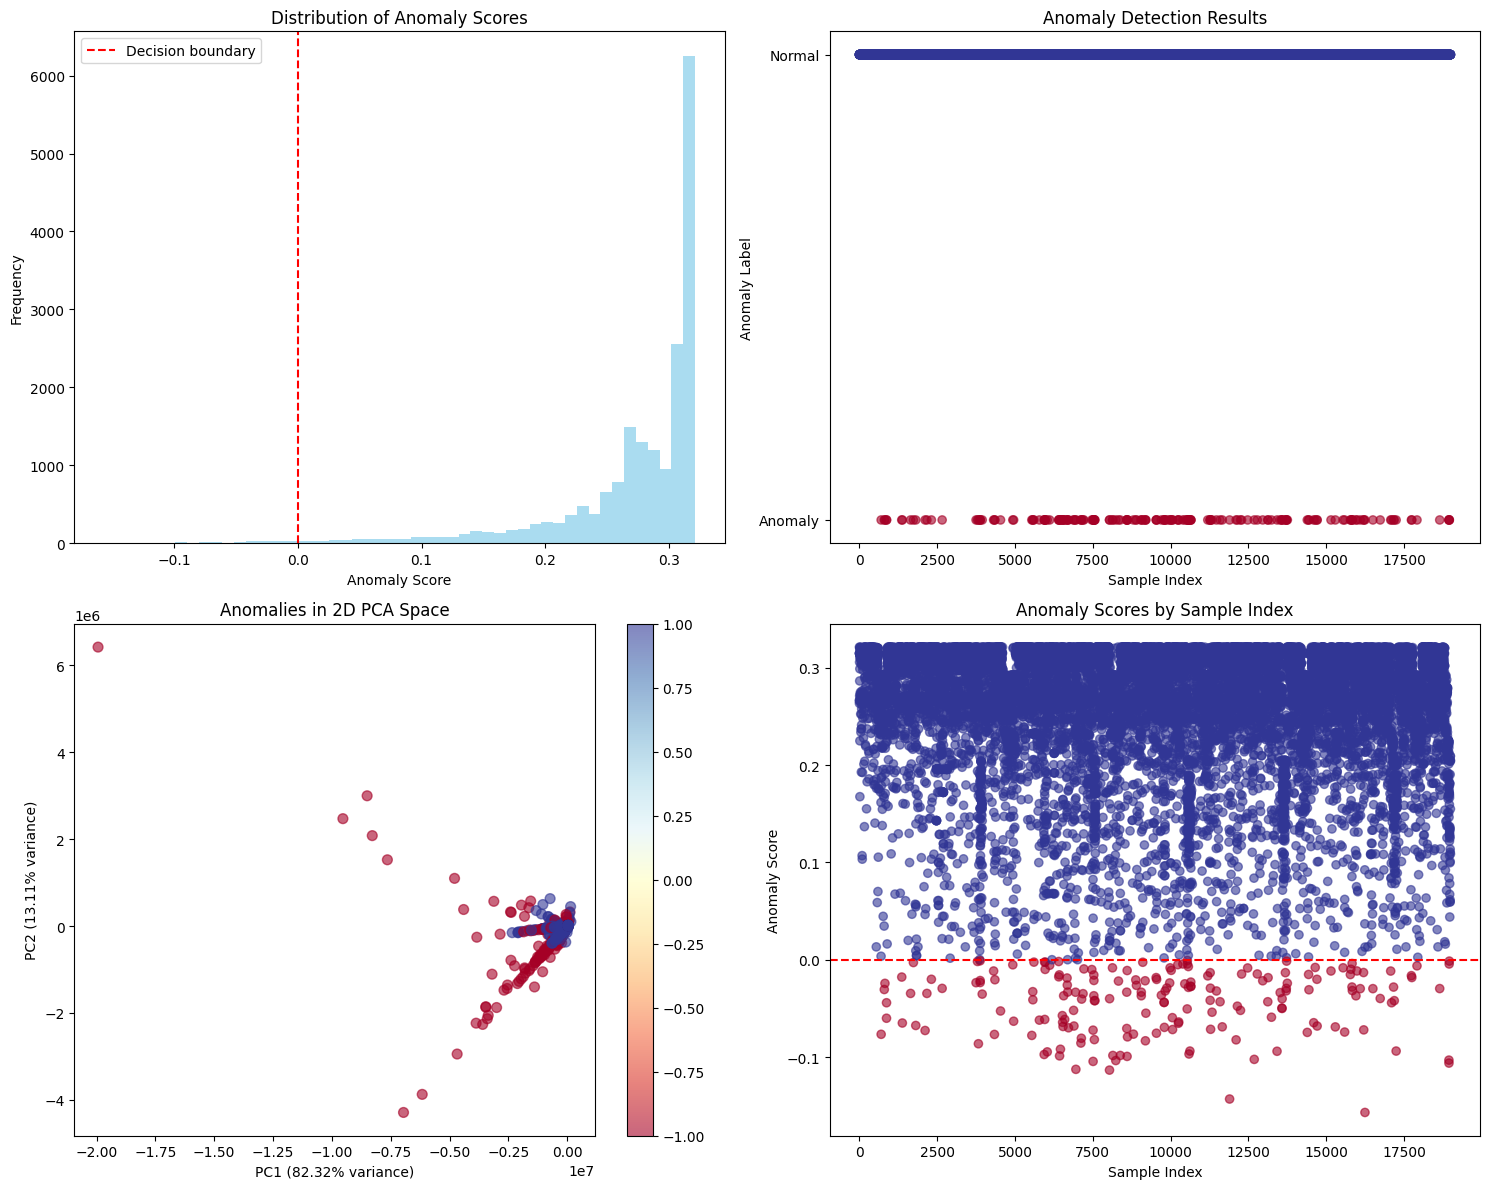

Isolation Forest Anomaly Detection Results:
Total samples: 18992
Detected anomalies: 189
Contamination rate: 0.010
Anomaly score range: [-0.157, 0.321]
Top 5 most anomalous samples (lowest scores):
  #1: Sample 16244, Score: -0.157
  #2: Sample 11895, Score: -0.143
  #3: Sample 8036, Score: -0.113
  #4: Sample 6956, Score: -0.113
  #5: Sample 18943, Score: -0.106


In [ ]:
# Apply the function
results = detect_anomalies_isolation_forest(
    df_numeric,
    contamination=0.01,
    n_estimators=50,
    visualize=True
)

In [159]:
final_df = results['new_df']
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18992 entries, 0 to 18991
Data columns (total 29 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Cr_Asset - Customer                             18992 non-null  float64
 1   Cr_Asset - G\L Account                          18992 non-null  float64
 2   Cr_Cost of Goods Sold (COGS) - G\L Account      18992 non-null  float64
 3   Cr_Liability - G\L Account                      18992 non-null  float64
 4   Cr_Other Costs - G\L Account                    18992 non-null  float64
 5   Cr_Other Revenue - G\L Account                  18992 non-null  float64
 6   Cr_Revenue - G\L Account                        18992 non-null  float64
 7   Dr_Asset - Customer                             18992 non-null  float64
 8   Dr_Asset - G\L Account                          18992 non-null  float64
 9   Dr_Cost of Goods Sold (COGS) - G\L Account  

In [163]:
# Add only the missing anomaly columns to original data_22
data_22_with_anomalies = add_anomaly_columns_to_original_df(data_22, final_df)
data_22_with_anomalies.info()


➕ Adding the following columns to the original DataFrame: ['anomaly_score', 'is_anomaly']
<class 'pandas.core.frame.DataFrame'>
Index: 18992 entries, 0 to 18991
Data columns (total 66 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   FiscalYear                                  18992 non-null  int64  
 1   AccDocNo                                    18992 non-null  int64  
 2   Dr_Cr                                       18992 non-null  object 
 3   DateOfAccDocEntry                           18992 non-null  object 
 4   DateOfAccDocEntry_and_TimeOfEntry (MYT)     18992 non-null  object 
 5   NoOfLineItemInAccDoc                        18992 non-null  object 
 6   RefKeyForLineItem                           18992 non-null  object 
 7   GL_DESCRIPTION                              18992 non-null  object 
 8   Amt_localCurrencyFormatted                  18992 non-null  object 
 9

In [164]:
data_22_with_anomalies.to_excel(rf"D:\victoriaquek\JE ML 2025\Results\siewpl_iso.xlsx")

### Get ZOTC

In [154]:
##### Import data 
sql_db=Conn_ODBC(database="JE_ML_2025")

conn=sql_db.odbc_conn_db_pyodbc()

sql_query=f"SELECT * FROM [data_ishi_ZOTC_combined]"
zotc = sql_db.odbc_run_sql(conn, sql_query, return_result=True)

conn.close()

In [155]:
zotc_siew = zotc[zotc['IS Rep']=='SIEW PENG LAU'][['IS Rep','Invoice Number', 'Sold-To Id', 'Customer PO Number']]
zotc_siew.rename(columns={'Invoice Number': 'AccDocNo'}, inplace=True)
zotc_siew.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41735 entries, 107 to 2820728
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   IS Rep              41735 non-null  object 
 1   AccDocNo            41735 non-null  float64
 2   Sold-To Id          41735 non-null  object 
 3   Customer PO Number  41735 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.6+ MB


In [156]:
import pandas as pd

def group_by_accdocno_smart_flatten(df, exclude_cols=None):
    """
    Groups DataFrame by 'AccDocNo', aggregates other columns into lists,
    and flattens to single value if all elements in the list are identical.

    Parameters:
    -----------
    df : pd.DataFrame
        Input DataFrame with 'AccDocNo' and other columns.
    exclude_cols : list, optional
        Columns to exclude from grouping/aggregation.

    Returns:
    --------
    pd.DataFrame
        One row per AccDocNo, with lists only where multiple distinct values exist.
    """
    
    if 'AccDocNo' not in df.columns:
        raise ValueError("Column 'AccDocNo' not found in DataFrame.")
    
    # Clean: drop rows with missing AccDocNo
    df_clean = df.dropna(subset=['AccDocNo']).copy()
    
    # Determine columns to process
    cols_to_agg = df_clean.columns.tolist()
    if exclude_cols:
        cols_to_agg = [col for col in cols_to_agg if col not in exclude_cols]
    
    # Remove AccDocNo from aggregation list
    feature_cols = [col for col in cols_to_agg if col != 'AccDocNo']
    
    # Define aggregation: collect all as lists
    agg_dict = {col: list for col in feature_cols}
    
    # Group by AccDocNo
    grouped = df_clean.groupby('AccDocNo', as_index=False).agg(agg_dict)
    
    # Define a helper function to flatten if all values are the same
    def flatten_if_uniform(val_list):
        if not val_list:
            return None
        # Get distinct values (handle unhashable like dicts/lists with fallback)
        try:
            distinct = set(val_list)
            if len(distinct) == 1:
                return val_list[0]  # return the single unique value
            return val_list  # keep as list if multiple distinct values
        except TypeError:
            # Fallback for unhashable types (e.g., dicts, lists)
            for i in range(1, len(val_list)):
                if val_list[i] != val_list[0]:
                    return val_list  # not uniform, keep list
            return val_list[0]  # all equal
        except Exception:
            return val_list  # fallback: keep list

    # Apply flattening to each column
    for col in feature_cols:
        grouped[col] = grouped[col].apply(flatten_if_uniform)
    
    return grouped

In [157]:
test = group_by_accdocno_smart_flatten(zotc_siew)  # example: exclude LineItem
test.info()
test.head(6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19346 entries, 0 to 19345
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   AccDocNo            19346 non-null  float64
 1   IS Rep              19346 non-null  object 
 2   Sold-To Id          19346 non-null  object 
 3   Customer PO Number  19346 non-null  object 
dtypes: float64(1), object(3)
memory usage: 604.7+ KB


,AccDocNo,IS Rep,Sold-To Id,Customer PO Number
0,9.900468e+09,SIEW PENG LAU,APEX COMMUNICATIONS SDN BHD,5821-MRT-PMO-004
1,9.900546e+09,SIEW PENG LAU,CTC GLOBAL SDN BHD,8500008426
2,9.900556e+09,SIEW PENG LAU,CTC GLOBAL SDN BHD,8400061160
3,9.900588e+09,SIEW PENG LAU,CD INTEGRATED SDN BHD,13012154
4,9.900634e+09,SIEW PENG LAU,MUTIARA SMART SDN BHD,109404-BSN
5,9.900635e+09,SIEW PENG LAU,SISTEM RKK SDN BHD,626733


In [165]:
# Now merge with GL
result = pd.merge(
    data_22_with_anomalies,
    test,
    on='AccDocNo',
    how='left'
)

In [166]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18992 entries, 0 to 18991
Data columns (total 69 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   FiscalYear                                  18992 non-null  int64  
 1   AccDocNo                                    18992 non-null  int64  
 2   Dr_Cr                                       18992 non-null  object 
 3   DateOfAccDocEntry                           18992 non-null  object 
 4   DateOfAccDocEntry_and_TimeOfEntry (MYT)     18992 non-null  object 
 5   NoOfLineItemInAccDoc                        18992 non-null  object 
 6   RefKeyForLineItem                           18992 non-null  object 
 7   GL_DESCRIPTION                              18992 non-null  object 
 8   Amt_localCurrencyFormatted                  18992 non-null  object 
 9   Document Type Description                   18992 non-null  object 
 10  Quantity  

In [167]:
result.to_excel(rf"D:\victoriaquek\JE ML 2025\Results\siewpl_zotc_iso.xlsx")

# Grading

## Get data

In [ ]:
sql_db=Conn_ODBC(database="JE_ML_2025")

conn=sql_db.odbc_conn_db_pyodbc()

sql_query=f"""
select distinct accdocno from data_ishi_GL_cleaned_2019 where accdocno like '99%' and DocNoOfClearingDoc in (
select DISTINCT AccDocNo from data_ishi_GL_cleaned_2019 where AccDocNo in 
(SELECT DISTINCT DocNoOfClearingDoc FROM data_ishi_GL_cleaned_2019 WHERE DocNoOfClearingDoc IS NOT NULL AND AccDocNo LIKE '99%')
AND REPLACE(REPLACE(RefKeyForLineItem, ' ',''), '/','') LIKE '%OPMT%'
)
"""

overpayment_accdocnos = sql_db.odbc_run_sql(conn, sql_query, return_result=True)
conn.close()
overpayment_accdocnos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12003 entries, 0 to 12002
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   accdocno  12003 non-null  int64
dtypes: int64(1)
memory usage: 93.9 KB


In [ ]:
sql_db=Conn_ODBC(database="JE_ML_2025")

conn=sql_db.odbc_conn_db_pyodbc()

sql_query=f"""
select distinct accdocno from data_ishi_GL_cleaned_2019 where AccDocNo in (
select distinct [Invoice Number] from data_ishi_ZOTC_comb_2019 where [IS Rep] like '%seok yee%' and Vendor like '%hp%'
)
"""
hp = sql_db.odbc_run_sql(conn, sql_query, return_result=True)
conn.close()

hp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638 entries, 0 to 637
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   accdocno  638 non-null    int64
dtypes: int64(1)
memory usage: 5.1 KB


In [ ]:
sql_db=Conn_ODBC(database="JE_ML_2025")

conn=sql_db.odbc_conn_db_pyodbc()

sql_query=f"""
select distinct accdocno from data_ishi_GL_cleaned_2019 where AccDocNo in (
select distinct [Invoice Number] from data_ishi_ZOTC_comb_2019 where [IS Rep] like '%seok yee%' and Vendor like '%microsoft%'
)
"""
microsoft=sql_db.odbc_run_sql(conn, sql_query, return_result=True)

microsoft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   accdocno  107 non-null    int64
dtypes: int64(1)
memory usage: 988.0 bytes


## Run

In [37]:
data_22_with_anomalies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156740 entries, 0 to 156739
Data columns (total 83 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   FiscalYear                                  156740 non-null  int64         
 1   AccDocNo                                    156740 non-null  int64         
 2   Dr_Cr                                       156740 non-null  object        
 3   DateOfAccDocEntry                           156740 non-null  object        
 4   DateOfAccDocEntry_and_TimeOfEntry (MYT)     156740 non-null  datetime64[ns]
 5   NoOfLineItemInAccDoc                        156740 non-null  object        
 6   GL_DESCRIPTION                              156740 non-null  object        
 7   Amt_localCurrencyFormatted                  156740 non-null  object        
 8   Document Type Description                   156740 non-null  object       

In [38]:
anomaly_df = data_22_with_anomalies[data_22_with_anomalies['is_anomaly'] == 1].copy()
anomaly_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1566 entries, 617 to 155229
Data columns (total 83 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   FiscalYear                                  1566 non-null   int64         
 1   AccDocNo                                    1566 non-null   int64         
 2   Dr_Cr                                       1566 non-null   object        
 3   DateOfAccDocEntry                           1566 non-null   object        
 4   DateOfAccDocEntry_and_TimeOfEntry (MYT)     1566 non-null   datetime64[ns]
 5   NoOfLineItemInAccDoc                        1566 non-null   object        
 6   GL_DESCRIPTION                              1566 non-null   object        
 7   Amt_localCurrencyFormatted                  1566 non-null   object        
 8   Document Type Description                   1566 non-null   object        
 9   Quantity 

In [39]:
# Checking WC in customer PO number
def contains_wc(lst):
    if not isinstance(lst, list):
        return False
    return any(isinstance(s, str) and 'WC' in s.upper() for s in lst)

# Testing
test = data_22_with_anomalies['Customer PO Number'].apply(contains_wc)
test[test]

4102      True
5136      True
89365     True
89567     True
90776     True
          ... 
147727    True
149262    True
149536    True
149724    True
151914    True
Name: Customer PO Number, Length: 73, dtype: bool

In [40]:
# Build sets for fast lookup
hp_docs = (
    set(hp['accdocno'].dropna().astype(str).str.strip().str.upper())
    if hp is not None and 'accdocno' in hp.columns else set()
)
microsoft_docs = (
    set(microsoft['accdocno'].dropna().astype(str).str.strip().str.upper())
    if microsoft is not None and 'accdocno' in microsoft.columns else set()
)

people = ['kam keong choy','pooi yee ho','seok yee chow']
# kam keong choy is also an OS rep

def check_is_rep_and_accdocno(is_rep_val, accdocno_val):
    # Extract IS Rep name
    if isinstance(is_rep_val, list) and len(is_rep_val) > 0:
        rep_name = str(is_rep_val[0]).strip()
    elif pd.notna(is_rep_val):
        rep_name = str(is_rep_val).strip()
    else:
        return False, ""

    # Check if IS Rep is in the allowed list (case-insensitive)
    if rep_name.lower() not in [p.lower() for p in people]:
        return False, ""

    # Normalize AccDocNo
    accdocno_str = str(accdocno_val).strip().upper() if pd.notna(accdocno_val) else ""

    # Check which source it belongs to
    if accdocno_str in hp_docs:
        return True, f"{rep_name}, hp"
    elif accdocno_str in microsoft_docs:
        return True, f"{rep_name}, microsoft"
    else:
        return False, ""  # No match if AccDocNo not in either
    
print(len(hp_docs))
print(len(microsoft_docs))

# Testing
match_results = anomaly_df.apply(
    lambda row: check_is_rep_and_accdocno(row['IS Rep'], row['AccDocNo']),
    axis=1
)

# Filter rows where the first element of the tuple is True
matched_df = match_results[match_results.apply(lambda x: x[0])]

# Optional: Extract the source info (second element of the tuple)
# matched_df['source_info'] = matched_df['match_result'].apply(lambda x: x[1])

# Display result
matched_df

638
107


2914      (True, SEOK YEE CHOW, hp)
91895     (True, SEOK YEE CHOW, hp)
92000     (True, SEOK YEE CHOW, hp)
92190     (True, SEOK YEE CHOW, hp)
92547     (True, SEOK YEE CHOW, hp)
92701     (True, SEOK YEE CHOW, hp)
92704     (True, SEOK YEE CHOW, hp)
93062     (True, SEOK YEE CHOW, hp)
93143     (True, SEOK YEE CHOW, hp)
93148     (True, SEOK YEE CHOW, hp)
93174     (True, SEOK YEE CHOW, hp)
93201     (True, SEOK YEE CHOW, hp)
93202     (True, SEOK YEE CHOW, hp)
93271     (True, SEOK YEE CHOW, hp)
93272     (True, SEOK YEE CHOW, hp)
93653     (True, SEOK YEE CHOW, hp)
103516    (True, SEOK YEE CHOW, hp)
103934    (True, SEOK YEE CHOW, hp)
108024    (True, SEOK YEE CHOW, hp)
114181    (True, SEOK YEE CHOW, hp)
117586    (True, SEOK YEE CHOW, hp)
123405    (True, SEOK YEE CHOW, hp)
138811    (True, SEOK YEE CHOW, hp)
149381    (True, SEOK YEE CHOW, hp)
dtype: object

In [41]:
def match_os_rep(val):
    # Handle list or pd.Series: extract first element if non-empty, else use None
    if isinstance(val, (list, pd.Series)):
        val = val[0] if len(val) > 0 else None
    # Now convert to string only if not null/None, otherwise use empty string
    val = str(val).strip().lower() if pd.notna(val) else ""
    return val in people

In [42]:
def add_probability_column(df):
    # Initialize probability column with 0s
    df = df.copy()  # Avoid modifying the original DataFrame
    df['probability'] = 0
    df['matched_conditions'] = [[] for _ in range(len(df))]  # List of strings for each row

    # Merged Condition 1 & 2: Either Carrier Key Desc == 'WILL CALL' OR Customer PO has 'WC'
    cond1_met = pd.Series([False] * len(df))
    cond2_met = pd.Series([False] * len(df))

    if 'Carrier Key Desc' in df.columns:
        carrier_desc = df['Carrier Key Desc'].astype(str).str.strip().str.upper()
        cond1_met = (carrier_desc == 'WILL CALL') | (carrier_desc == 'WILLCALL')  # Handle minor variation
        cond1_met = cond1_met.fillna(False)

    if 'Customer PO Number' in df.columns:
        cond2_met = df['Customer PO Number'].apply(contains_wc)
        cond2_met = cond2_met.fillna(False)

    # Combined condition: if either is True, add 1 to probability
    combined_cond = cond1_met | cond2_met
    df['probability'] += combined_cond.astype(int)

    # For rows where either condition is True, record which ones matched
    def update_matched_conditions(row):
        matches = []
        if 'Carrier Key Desc' in df.columns and row['cond1_met']:
            matches.append('Carrier Key Desc')
        if 'Customer PO Number' in df.columns and row['cond2_met']:
            matches.append('Customer PO Number')
        return matches

    # Temporarily add helper columns to track which sub-condition matched
    df['cond1_met'] = cond1_met
    df['cond2_met'] = cond2_met

    # Update matched_conditions only where combined condition is True
    temp_matches = df[combined_cond].apply(update_matched_conditions, axis=1)
    for idx, matches in temp_matches.items():
        df.at[idx, 'matched_conditions'] = df.at[idx, 'matched_conditions'] + matches

    # Clean up temporary columns
    df = df.drop(['cond1_met', 'cond2_met'], axis=1)

    # Condition 3: Check IS Rep and Vendor
    if 'IS Rep' in df.columns:
        # Apply the function row by row
        match_results = df.apply(
            lambda row: check_is_rep_and_accdocno(row['IS Rep'], row['AccDocNo']),
            axis=1
        )

        # Unpack results
        df['cond3_match'] = match_results.apply(lambda x: x[0])
        df['cond3_label'] = match_results.apply(lambda x: x[1])

        # Only update where both IS Rep and AccDocNo match
        cond3 = df['cond3_match']
        df['probability'] += cond3.astype(int)
        df['probability'] += cond3.astype(int)
        
        for idx in df[cond3].index:
            df.at[idx, 'matched_conditions'].append(df.at[idx, 'cond3_label'])

        df = df.drop('cond3_match', axis=1)
        df = df.drop('cond3_label', axis=1)


    # Condition 4: Check OS Rep
    if 'OS Rep' in df.columns:
        def match_os_rep(val):
            val=val[0] if val else ""
            return val.strip().lower() in people

        cond4 = df['OS Rep'].apply(match_os_rep)
        cond4 = cond4.fillna(False)
        df['probability'] += cond4.astype(int)
        df.loc[cond4, 'matched_conditions'] = df.loc[cond4, 'matched_conditions'].apply(lambda x: x + ['OS Rep'])


    # Condition 5: RefKeyForLineItem like O / PMT
    if 'AccDocNo' in df.columns and overpayment_accdocnos is not None and 'accdocno' in overpayment_accdocnos.columns:
        # Extract the set of AccDocNo values from the overpayment DataFrame
        valid_accdocnos = set(overpayment_accdocnos['accdocno'].dropna().astype(str).str.strip().str.upper())
        # Match if AccDocNo is in the overpayment list (case-insensitive)
        cond5 = df['AccDocNo'].astype(str).str.strip().str.upper().isin(valid_accdocnos)
        cond5 = cond5.fillna(False)
        df['probability'] += cond5.astype(int)
        df.loc[cond5, 'matched_conditions'] = df.loc[cond5, 'matched_conditions'].apply(lambda x: x + ['AccDocNo (Overpayment)'])

    return df

In [43]:
final = add_probability_column(anomaly_df)

final.groupby('probability')['AccDocNo'].count()

probability
0    1380
1     159
2      25
3       2
Name: AccDocNo, dtype: int64

In [44]:
final['matched_conditions'].value_counts()

matched_conditions
[]                                            1380
[AccDocNo (Overpayment)]                       117
[Carrier Key Desc]                              42
[SEOK YEE CHOW, hp]                             22
[Carrier Key Desc, AccDocNo (Overpayment)]       3
[Carrier Key Desc, SEOK YEE CHOW, hp]            2
Name: count, dtype: int64

In [45]:
overall = add_probability_column(data_22_with_anomalies)
overall.groupby('probability')['AccDocNo'].count()
# probability
# 0    147350
# 1      9193
# 2       197

# probability
# 0    137689
# 1     18592
# 2       442
# 3        16
# 4         1

probability
0    137689
1     18592
2       442
3        16
4         1
Name: AccDocNo, dtype: int64

In [46]:
overall['matched_conditions'].value_counts()

matched_conditions
[]                                                               137689
[AccDocNo (Overpayment)]                                          11794
[Carrier Key Desc]                                                 6727
[Carrier Key Desc, AccDocNo (Overpayment)]                          205
[SEOK YEE CHOW, hp]                                                 195
[Carrier Key Desc, Customer PO Number]                               55
[SEOK YEE CHOW, microsoft]                                           39
[Customer PO Number]                                                 16
[Carrier Key Desc, SEOK YEE CHOW, hp]                                12
[Carrier Key Desc, SEOK YEE CHOW, microsoft]                          3
[Customer PO Number, AccDocNo (Overpayment)]                          2
[SEOK YEE CHOW, hp, AccDocNo (Overpayment)]                           1
[Carrier Key Desc, OS Rep]                                            1
[Carrier Key Desc, SEOK YEE CHOW, hp, AccDocN

In [ ]:
# Save evaluated / graded results
overall.to_excel(rf"D:\victoriaquek\JE ML 2025\Results\anomaly_res_22.xlsx")
# final.to_excel(rf"D:\victoriaquek\JE ML 2025\Results\anomaly_res_manual_and_k_merged.xlsx")

# Explaining results

In [ ]:
# Optional: Use PCA for linear projection (faster, more interpretable)
# Or t-SNE for non-linear, cluster-focused view (better for complex structures)

# Choose one of the two methods below:

# ----------------------------
# Option 1: PCA (Recommended for simplicity and speed)
# ----------------------------

pca = PCA(n_components=2, random_state=42)
data_2d = pca.fit_transform(df_numeric)

# Convert to DataFrame for easier plotting
plot_df = pd.DataFrame(data_2d, columns=['PC1', 'PC2'])
plot_df['anomaly'] = y_pred
plot_df['anomaly'] = plot_df['anomaly'].map({1: 'Normal', -1: 'Anomalous'})

# ----------------------------
# Option 2: t-SNE (Better for capturing local structure, but slower)
# ----------------------------
# tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
# data_2d = tsne.fit_transform(df_numeric)

# plot_df = pd.DataFrame(data_2d, columns=['Dim1', 'Dim2'])
# plot_df['anomaly'] = y_pred
# plot_df['anomaly'] = plot_df['anomaly'].map({1: 'Normal', -1: 'Anomalous'})

# ----------------------------
# Create the scatter plot
# ----------------------------
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=plot_df, 
    x='PC1', y='PC2',
    hue='anomaly',
    palette={'Normal': 'blue', 'Anomalous': 'red'},
    alpha=0.7,
    s=60,
    edgecolor='k', linewidth=0.3
)

plt.title('Data Structure: Normal vs Anomalous Points (PCA Projection)', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Point Type', loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
plot_df['anomaly_score'] = anomaly_scores

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    plot_df['PC1'], plot_df['PC2'],
    c=plot_df['anomaly_score'],
    cmap='RdYlBu_r',
    alpha=0.7,
    s=60,
    edgecolor='k',
    linewidth=0.3
)
plt.colorbar(scatter, label='Anomaly Score (lower = more anomalous)')
plt.title('Anomaly Scores in Projected Space (PCA)', fontsize=16)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

### Using SHAP<br>
Summary Plot: Gives a global view of feature importance and how values influence predictions<br>
<ul><li>Horizontal location shows whether the effect of that value is associated with a higher or lower prediction.</li>
<li>Color represents the original value of the feature.</li></ul>

Force Plot: Gives an interactive view of individual prediction explanations.<br>
This plot displays the positive and negative influences of features in a linear format

#### 1 group (Just K_cluster)

In [47]:
def run_isolation_forest_by_group(input_df, group_col, contamination='auto', compute_shap=False):
    results = []
    models = {}  # To store trained models per group
    shap_explanations = {}  # To store SHAP values per group (if requested)
    input_df_filled = input_df.copy()

    # Loop over each group
    input_df_filled[group_col] = input_df_filled[group_col].fillna('NAN')  # or any placeholder
    for group_name, group_data in input_df_filled.groupby(group_col):  #, dropna=False
        # print(f"\nRunning Isolation Forest on cluster/group: {group_name}")
        
        # Keep original index for mapping back
        original_index = group_data.index

        # Extract feature matrix
        X_in = group_data.drop(columns=[group_col], errors='ignore')

        # Scale features (recommended for better performance)
        # scaler = StandardScaler()
        # X_scaled = scaler.fit_transform(X)

        # Train Isolation Forest
        iso_forest = IsolationForest(
            n_estimators=50,             # default = 100
            max_features=1.0,
            max_samples='auto',
            contamination=contamination,
            random_state=42,
        )

        # iso_forest.fit(X_scaled)
        iso_forest.fit(X_in)

        # Predict anomaly scores and labels
        anomaly_scores = iso_forest.score_samples(X_in)    # Returns the raw anomaly score (log of average path length).
        predictions = iso_forest.predict(X_in)  # -1 = anomaly, 1 = normal

        # Count anomalies in this group
        num_anomalies = sum(predictions == -1)
        print(f"Cluster {group_name}: {num_anomalies} anomalies")

        # Add predictions to group_data
        group_result = pd.DataFrame({
            'anomaly_score': anomaly_scores,
            'is_anomaly': (predictions==-1),
            # 'is_anomaly_flag': (predictions == -1)
        }, index=original_index)

        # Append processed group
        results.append(group_result)
        models[group_name] = iso_forest  # Save model

        # 🔍 Compute SHAP values if requested
        if compute_shap:
            # Use TreeExplainer on the Isolation Forest
            explainer = shap.TreeExplainer(
                iso_forest,
                # feature_perturbation="interventional",  # or "tree_path_dependent"
                feature_perturbation="auto",  # or "tree_path_dependent"
                model_output='raw'  # score_samples output
            )
            shap_values = explainer.shap_values(X_in)
            shap_explanations[group_name] = {
                'shap_values': shap_values,
                'data': X_in,
                'explainer': explainer
            }

    # Concatenate all processed groups back into one DataFrame
    final_df = pd.concat(results)

    # # Ensure we preserve original order using original index
    final_df = final_df.reindex(input_df.index)

    if compute_shap:
        return final_df, models, shap_explanations
    else:
        return final_df

In [48]:
df_with_anomalies, models, shap_explanations = run_isolation_forest_by_group(df_num, group_col='K_cluster', contamination=0.01, compute_shap=True)

Cluster 0: 1015 anomalies
Cluster 1: 204 anomalies
Cluster 2: 199 anomalies
Cluster 3: 94 anomalies
Cluster 4: 54 anomalies


##### For each group

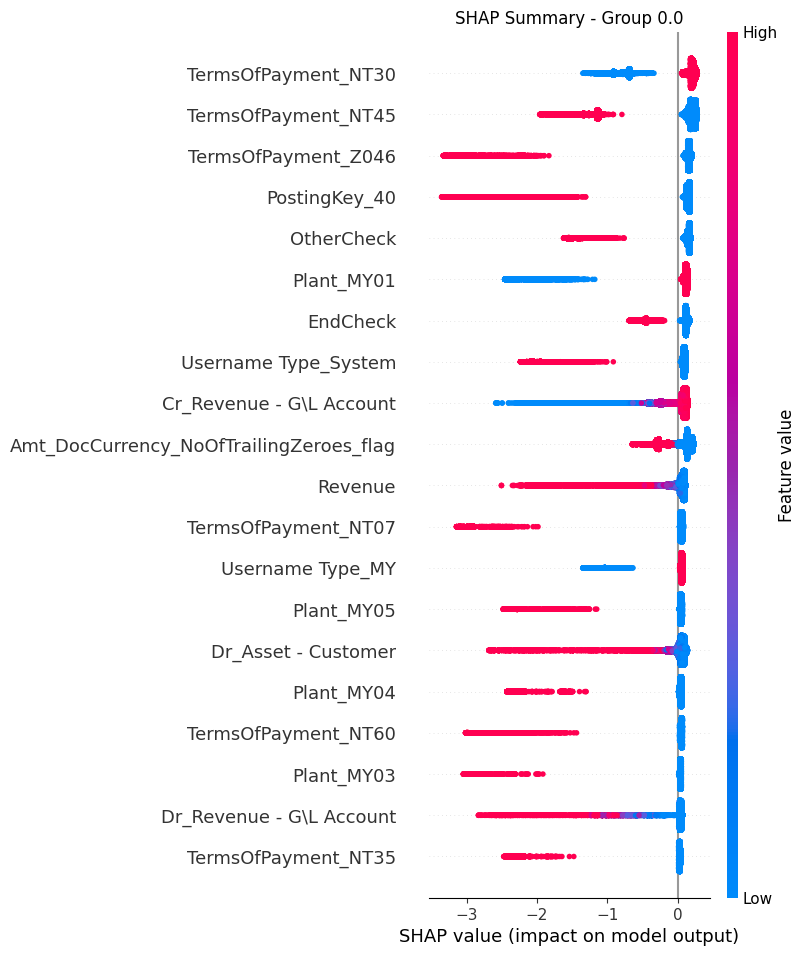

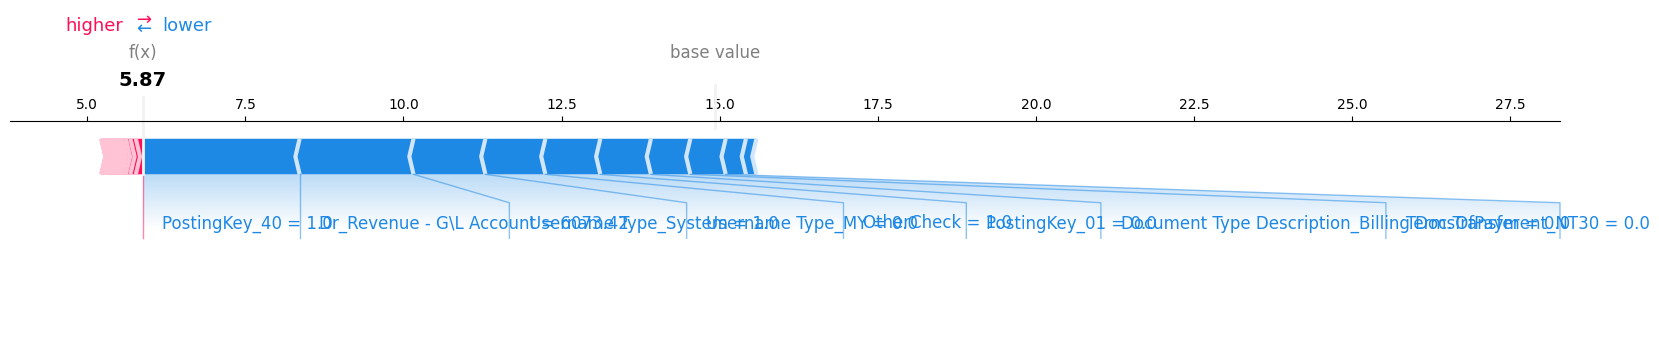

In [49]:
# Choose a group to analyze
group_name = 0.0  # or whatever your group is
if group_name in shap_explanations:
    shap_info = shap_explanations[group_name]
    shap_values = shap_info['shap_values']
    X_data = shap_info['data']

    # Summary plot
    shap.summary_plot(shap_values, X_data, show=False)
    plt.title(f"SHAP Summary - Group {group_name}")
    plt.show()

    # Force plot for first anomaly
    anomaly_mask = df_with_anomalies.loc[X_data.index, 'is_anomaly']
    if any(anomaly_mask):
        first_anomaly_idx = X_data[anomaly_mask].index[0]
        idx_in_group = X_data.index.get_loc(first_anomaly_idx)
        shap.force_plot(
            shap_info['explainer'].expected_value,
            shap_values[idx_in_group],
            X_data.loc[first_anomaly_idx],
            matplotlib=True
        )

Baseline value: model’s average prediction<br>
Shows how each feature contributes to the prediction and how the prediction evolves as features are added or removed.

In [50]:
# Set up plotting
shap.initjs()  # Required for force plots
force_plots = {}

# Loop through each group
for group_name, shap_info in shap_explanations.items():
    shap_values = shap_info['shap_values']  # SHAP values for this group
    X_data = shap_info['data']               # Original features
    explainer = shap_info['explainer']
    expected_value = explainer.expected_value

    # Get predictions/anomaly scores from the original results
    group_mask = df_with_anomalies.index.isin(X_data.index)
    group_scores = df_with_anomalies.loc[group_mask, 'anomaly_score'].loc[X_data.index]

    # 🔍 Find the most anomalous sample in this group
    most_anomalous_idx = group_scores.idxmin()  # Lowest score = most anomalous
    instance_idx_in_group = X_data.index.get_loc(most_anomalous_idx)  # Position in X_data

    print(f"Generating plots for Group '{group_name}', most anomalous sample: {most_anomalous_idx}")

    # Extract data for this instance
    instance_shap = shap_values[instance_idx_in_group]
    instance_features = X_data.loc[most_anomalous_idx]

    # --- Force Plot ---
    force_plot = shap.force_plot(
        expected_value,
        instance_shap,
        instance_features,
        link='identity',
        out_names='Anomaly Score')
    force_plots[group_name] = force_plot
    # Display (in Jupyter)
    display(force_plot)

Generating plots for Group '0', most anomalous sample: 102704


Generating plots for Group '1', most anomalous sample: 65075


Generating plots for Group '2', most anomalous sample: 101799


Generating plots for Group '3', most anomalous sample: 20387


Generating plots for Group '4', most anomalous sample: 85011


Generating plots for Group '0', most anomalous sample: 102704


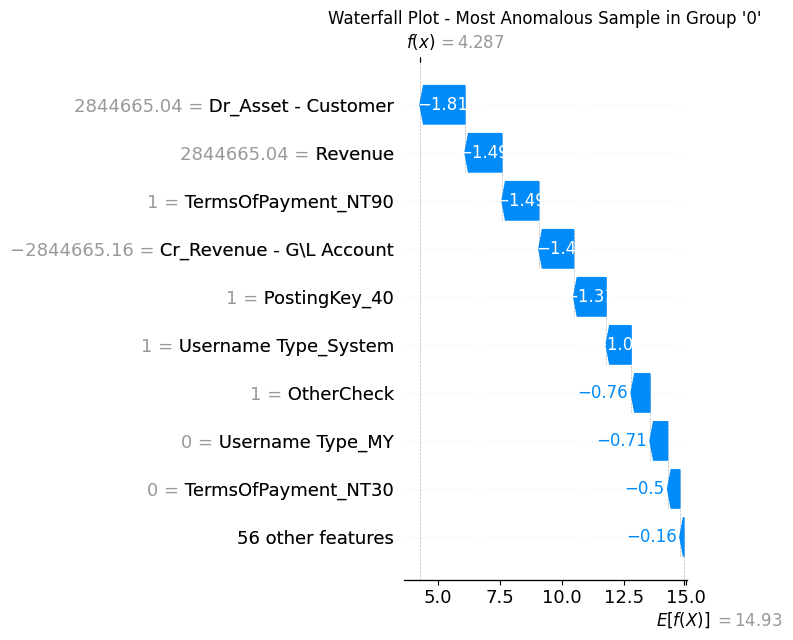

Generating plots for Group '1', most anomalous sample: 65075


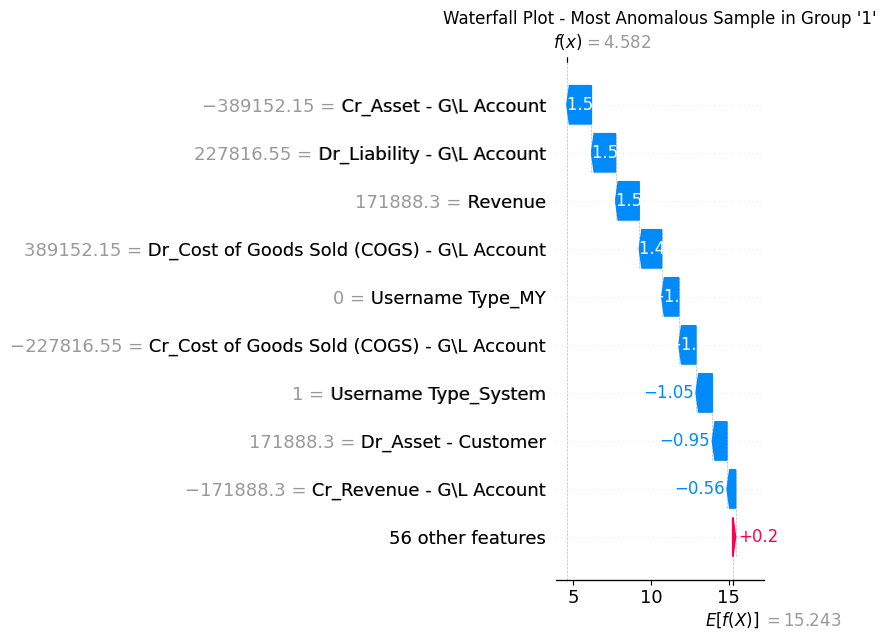

Generating plots for Group '2', most anomalous sample: 101799


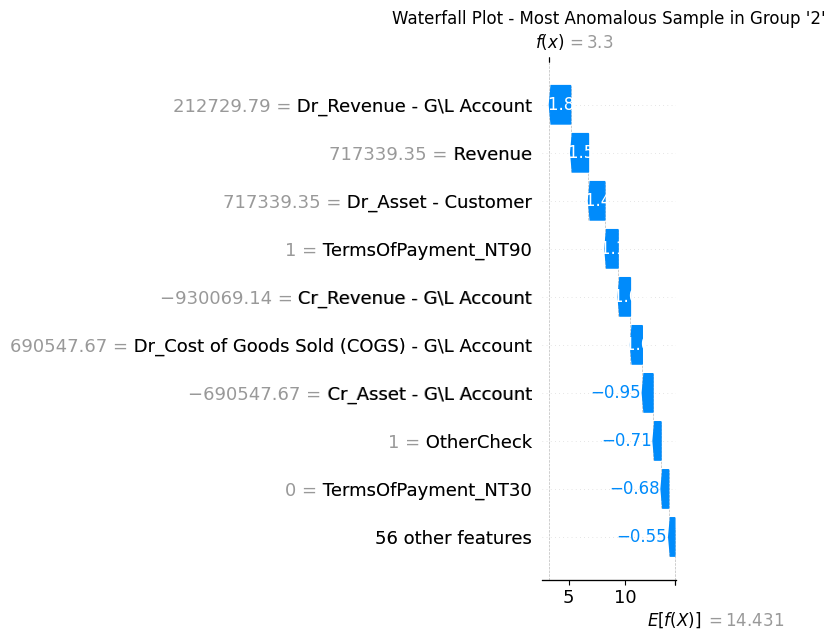

Generating plots for Group '3', most anomalous sample: 20387


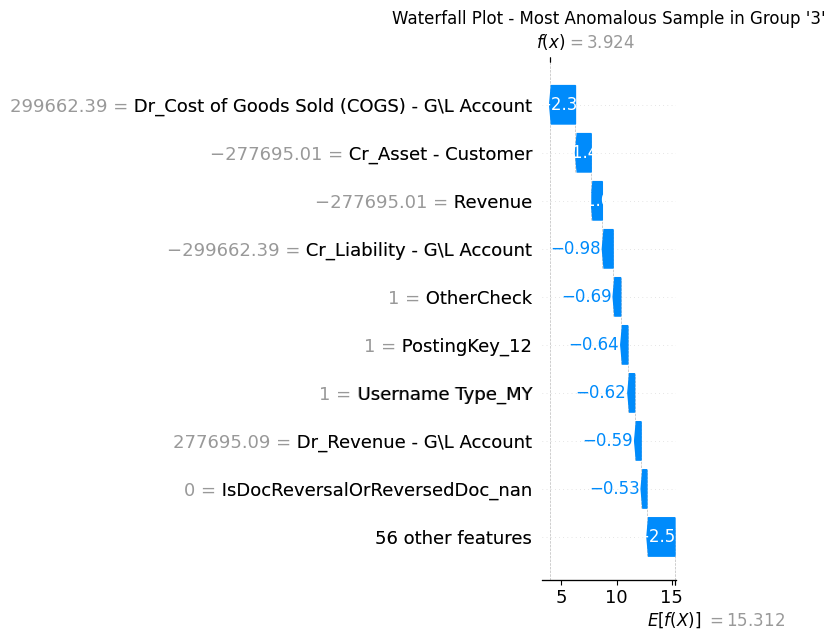

Generating plots for Group '4', most anomalous sample: 85011


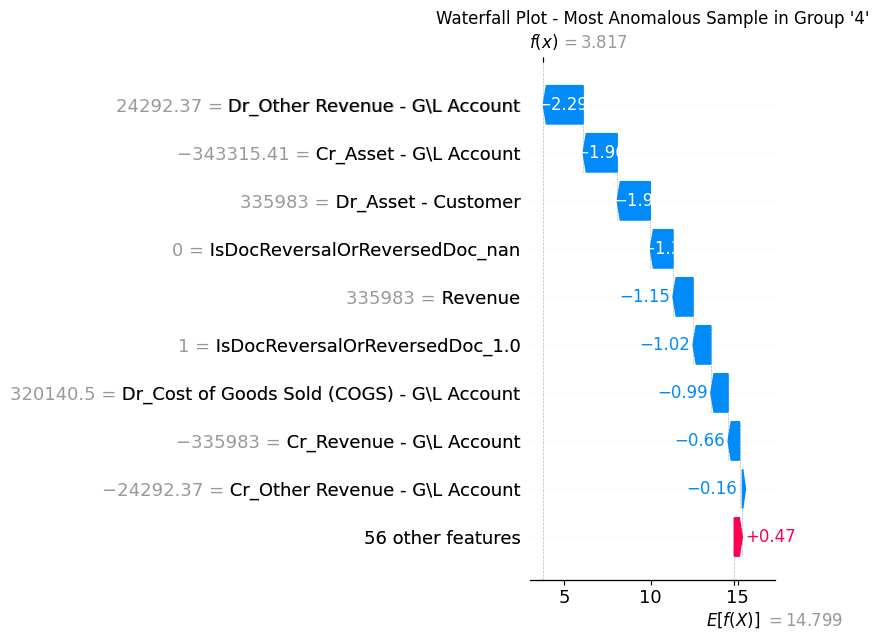

In [51]:
# To store individual plots (optional)
waterfall_figs = {}

# Loop through each group
for group_name, shap_info in shap_explanations.items():
    shap_values = shap_info['shap_values']  # SHAP values for this group
    X_data = shap_info['data']               # Original features
    explainer = shap_info['explainer']
    expected_value = explainer.expected_value

    # Get predictions/anomaly scores from the original results
    group_mask = df_with_anomalies.index.isin(X_data.index)
    group_scores = df_with_anomalies.loc[group_mask, 'anomaly_score'].loc[X_data.index]

    # 🔍 Find the most anomalous sample in this group
    most_anomalous_idx = group_scores.idxmin()  # Lowest score = most anomalous
    instance_idx_in_group = X_data.index.get_loc(most_anomalous_idx)  # Position in X_data

    print(f"Generating plots for Group '{group_name}', most anomalous sample: {most_anomalous_idx}")

    # Extract data for this instance
    instance_shap = shap_values[instance_idx_in_group]
    instance_features = X_data.loc[most_anomalous_idx]

    # --- Waterfall Plot ---
    fig, ax = plt.subplots(figsize=(8, 6))
    shap.waterfall_plot(
        shap.Explanation(values=instance_shap, base_values=expected_value, data=instance_features),
        show=False
    )
    plt.title(f"Waterfall Plot - Most Anomalous Sample in Group '{group_name}'")
    plt.tight_layout()
    plt.show()

    # Save figure if needed
    waterfall_figs[group_name] = fig


--- Group: 0 ---
Top 10 most anomalous samples


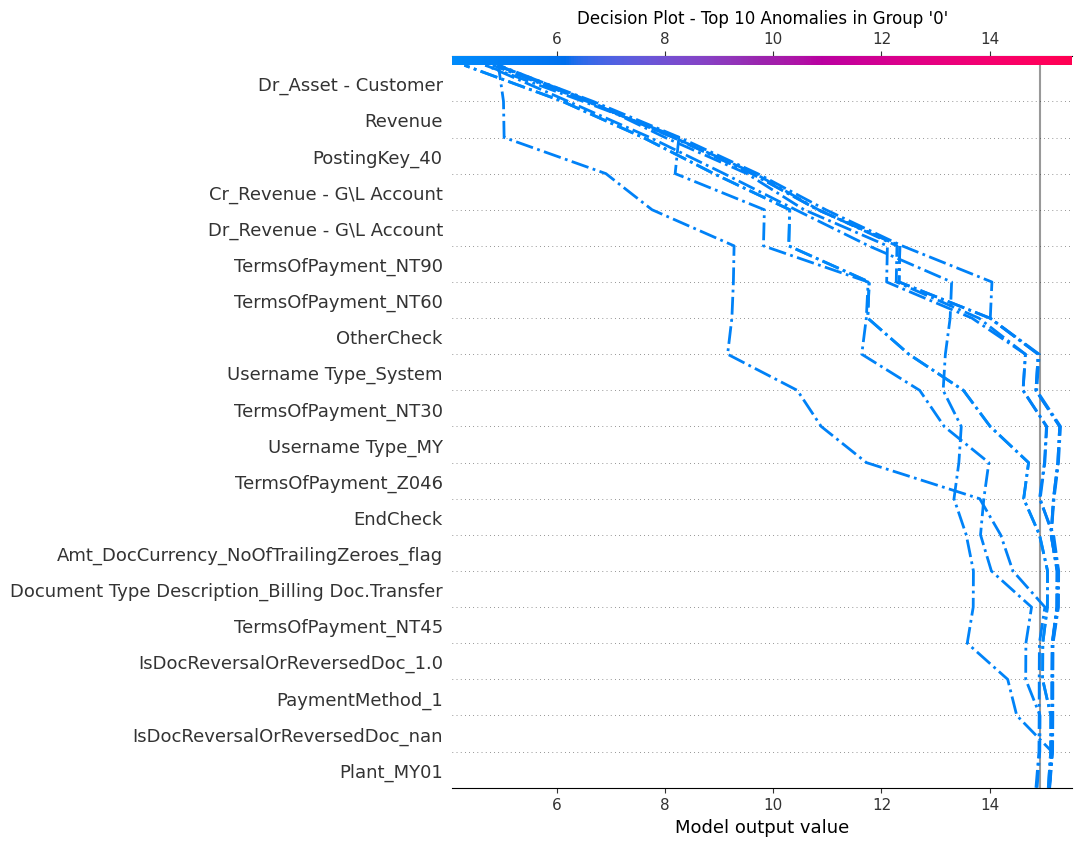


--- Group: 1 ---
Top 10 most anomalous samples


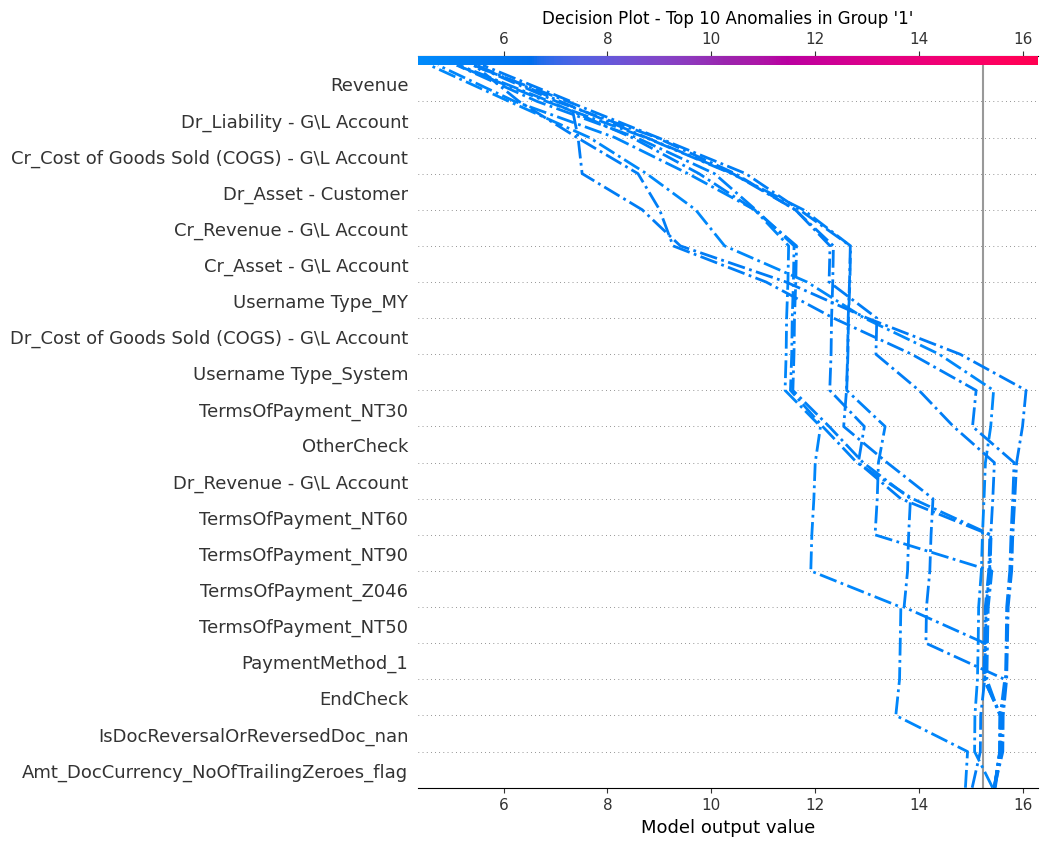


--- Group: 2 ---
Top 10 most anomalous samples


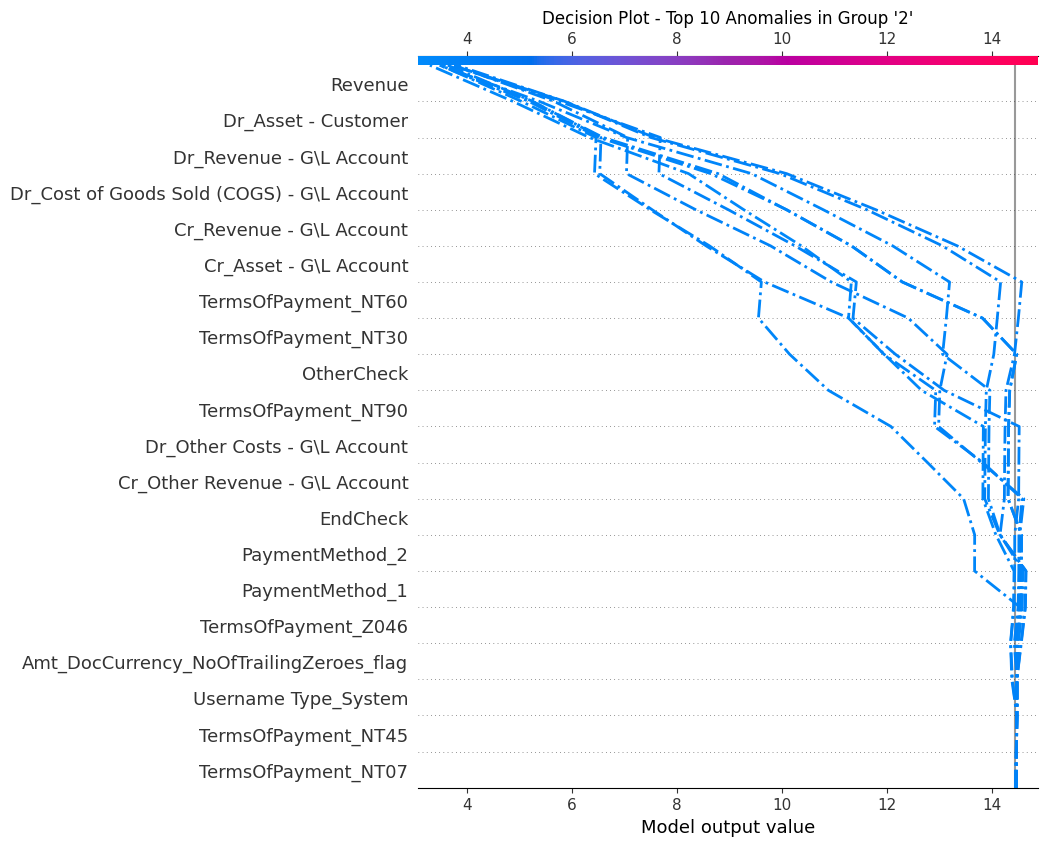


--- Group: 3 ---
Top 10 most anomalous samples


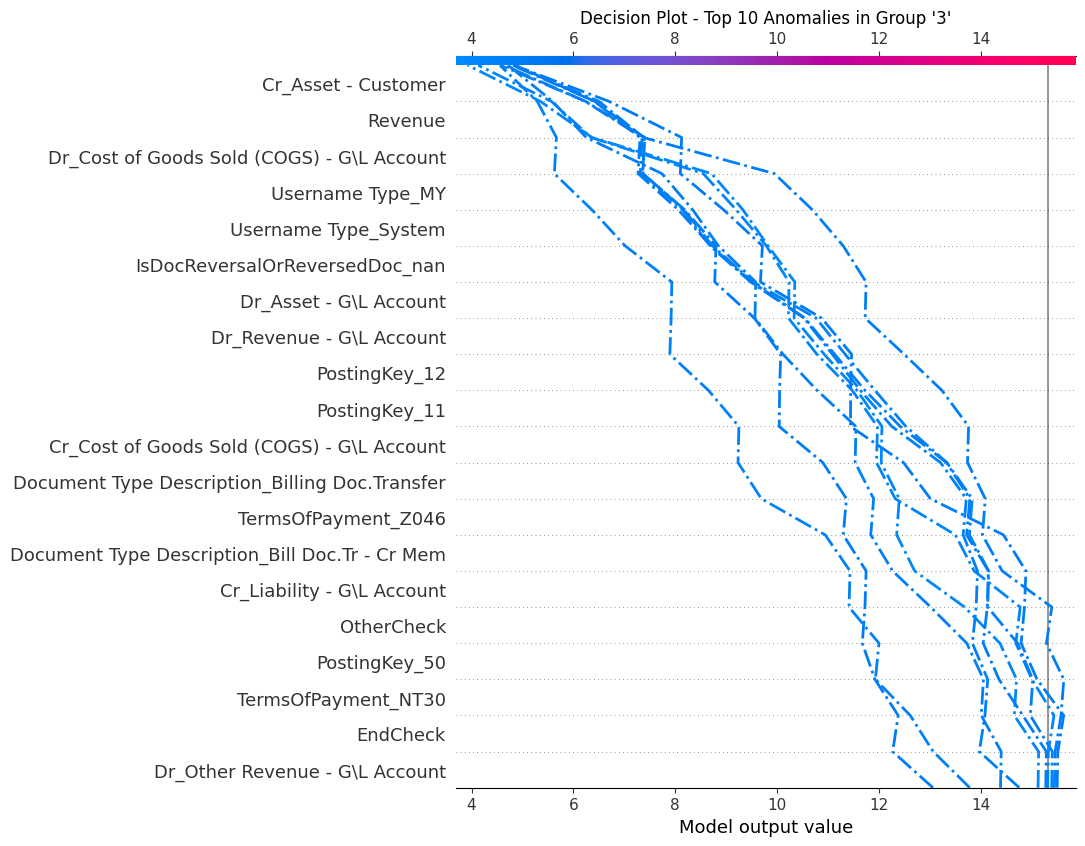


--- Group: 4 ---
Top 10 most anomalous samples


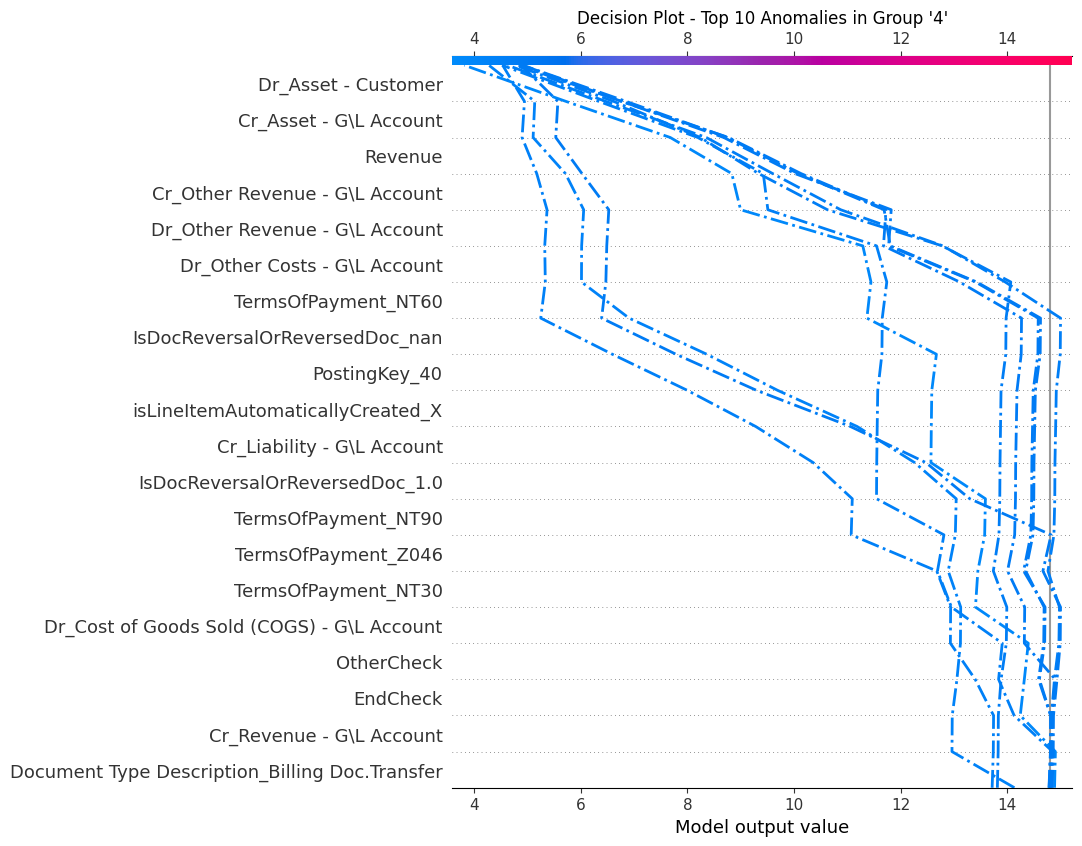

In [52]:
# Dictionary to store group-level plots
decision_plots_by_group = {}
stacked_force_plots_by_group = {}

for group_name, shap_info in shap_explanations.items():
    shap_values = shap_info['shap_values']  # Shape: (n_samples, n_features)
    X_data = shap_info['data']
    expected_value = shap_info['explainer'].expected_value

    # Get anomaly scores for this group from global results
    scores = df_with_anomalies.loc[X_data.index, 'anomaly_score']

    # Sort by most anomalous (lowest score)
    top_k = 10
    top_indices = scores.nsmallest(top_k).index
    idx_in_X = [X_data.index.get_loc(idx) for idx in top_indices]

    # Subset SHAP values for top-k anomalous
    shap_subset = shap_values[idx_in_X]
    feature_names = X_data.columns.tolist()
    instance_names = [f"Sample {i+1}" for i in range(len(shap_subset))]

    print(f"\n--- Group: {group_name} ---")
    print(f"Top {len(shap_subset)} most anomalous samples")

    # --- Decision Plot (Stacked Force Plot) ---
    fig1 = shap.decision_plot(
        expected_value,
        shap_subset,
        X_data.loc[top_indices],
        link='identity',
        feature_order='importance',
        feature_names=feature_names,
        highlight=np.arange(len(shap_subset)),
        title=f"Decision Plot - Top {top_k} Anomalies in Group '{group_name}'",
        show=False
    )
    plt.show()
    decision_plots_by_group[group_name] = fig1

    # Optional: Save as HTML (interactive)
    # shap.save_html(f"decision_group_{group_name}.html", fig1)

##### Overall population

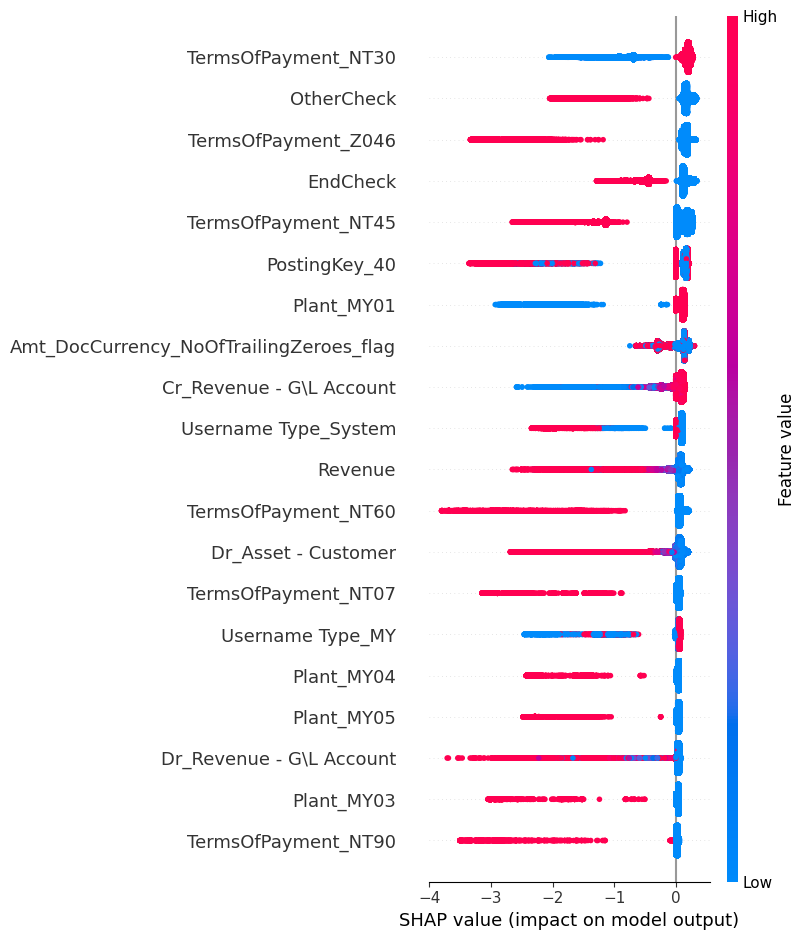

In [53]:
all_shap_values = []
all_features = []

for group_name, shap_info in shap_explanations.items():
    shap_vals = shap_info['shap_values']
    X_data = shap_info['data']
    all_shap_values.append(shap_vals)
    all_features.append(X_data)

# Combine
combined_shap = np.concatenate(all_shap_values)
combined_data = pd.concat(all_features)

# Global summary (beeswarm)
shap.summary_plot(combined_shap, combined_data)

Y-axis indicates the feature names in order of importance from top to bottom<br>
X-axis represents the SHAP value, which indicates the degree of change in log odds. It quantifies a feature’s influence on a specific prediction<br>
Each point represents a row of data from the original dataset.<br><br>

Those with more pink in the negative SHAP value means that higher counts for that feature tend to negatively affect the output

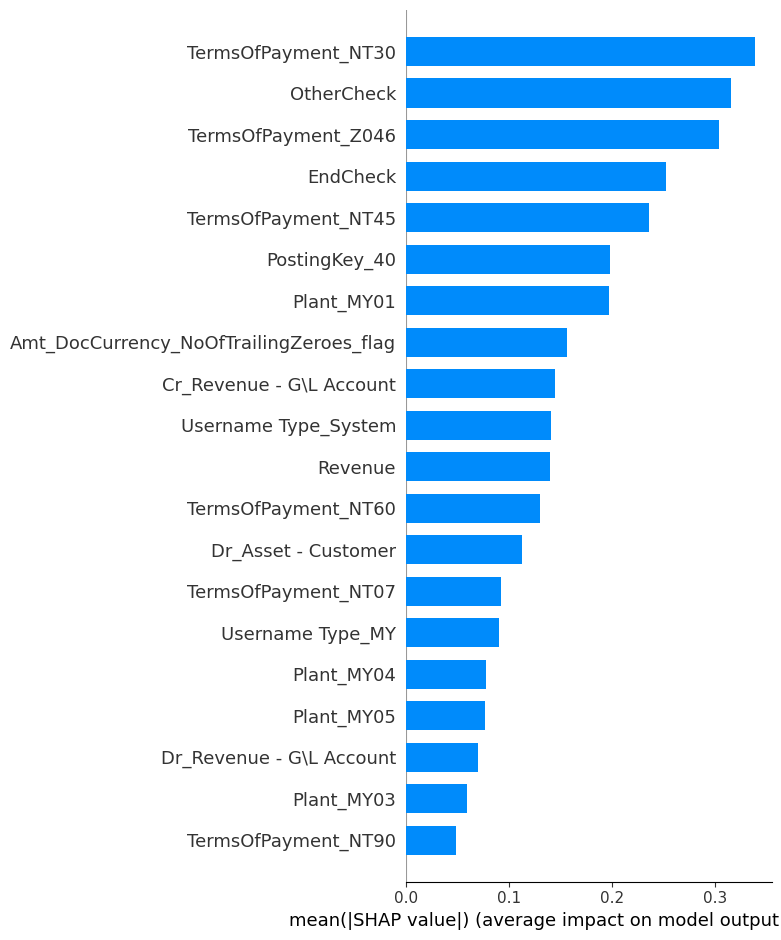

In [54]:
# Feature importance
shap.summary_plot(combined_shap, combined_data, plot_type="bar")

Most anomalous sample overall: 101799
Group: 2


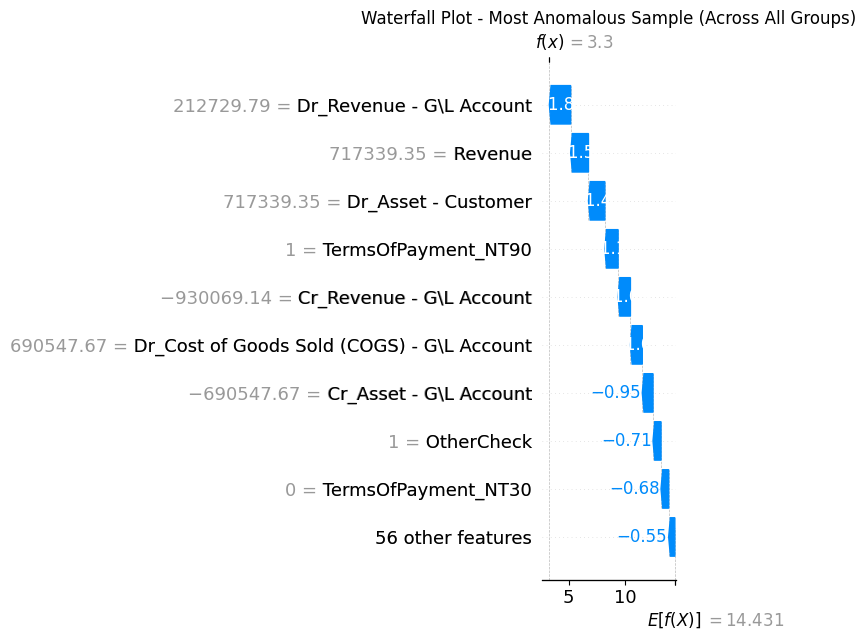

In [55]:
# Waterfall plot
# Find the globally most anomalous sample
most_anomalous_global = df_with_anomalies['anomaly_score'].idxmin()
print(f"Most anomalous sample overall: {most_anomalous_global}")

# Identify which group it belongs to
global_group_name = df_num.loc[most_anomalous_global, 'K_cluster']
if pd.isna(global_group_name):
    global_group_name = 'NAN'

print(f"Group: {global_group_name}")

# Get its SHAP info
shap_info = shap_explanations[global_group_name]
shap_values = shap_info['shap_values']
X_data = shap_info['data']
explainer = shap_info['explainer']
expected_value = explainer.expected_value

# Index of this sample in its group
idx_in_group = X_data.index.get_loc(most_anomalous_global)
instance_shap = shap_values[idx_in_group]
instance_features = X_data.loc[most_anomalous_global]

# --- Global Waterfall Plot ---
fig, ax = plt.subplots(figsize=(8, 6))
shap.waterfall_plot(
    shap.Explanation(values=instance_shap, base_values=expected_value, data=instance_features),
    show=False
)
plt.title("Waterfall Plot - Most Anomalous Sample (Across All Groups)")
plt.tight_layout()
plt.show()

In [56]:
# df_with_anomalies[]

Expected Value (E[f(x)]):
the average or baseline prediction of the model across a background dataset. It serves as the starting point of the waterfall.
<br>
Red = pushes prediction higher<br>
Blue = pushes prediction lower

In [57]:
# --- Global Force Plot --
shap.initjs()

global_force_plot=shap.force_plot(
    expected_value,
    instance_shap,
    instance_features,
    link='identity',
    out_names='Anomaly Score' 
)
display(global_force_plot)

##### 5 random anomalies

In [58]:
# --- 1. Find all anomalies ---
anomaly_mask = df_with_anomalies['is_anomaly'] == True  # Boolean mask for anomalies
anomaly_indices = df_with_anomalies[anomaly_mask].index.tolist()

if len(anomaly_indices) == 0:
    raise ValueError("No anomalies detected in the data.")

print(f"Total anomalies found: {len(anomaly_indices)}")

# --- 2. Randomly sample 5 anomalies ---
np.random.seed(42)  # For reproducibility (optional: remove for true randomness)
selected_anomaly_indices = np.random.choice(anomaly_indices, size=min(5, len(anomaly_indices)), replace=False)

print("Randomly selected anomaly indices:")
print(selected_anomaly_indices)

Total anomalies found: 1566
Randomly selected anomaly indices:
[ 55502  37996 150595 124045  11402]


In [59]:
shap_values_list = []   # To store SHAP values for each selected anomaly
feature_data_list = []  # To store corresponding feature values
instance_names = []     # Friendly labels: Anomaly 1, 2, ...

for sample_idx in selected_anomaly_indices:
    # Get the group this sample belongs to
    group_val = df_num.loc[sample_idx, 'K_cluster']
    if pd.isna(group_val):
        group_val = 'NAN'

    # Access the SHAP explanation for this group
    if group_val not in shap_explanations:
        print(f"⚠️ Group '{group_val}' not in shap_explanations. Skipping sample {sample_idx}.")
        continue

    shap_info = shap_explanations[group_val]
    X_group = shap_info['data']           # Features for this group
    shap_vals_group = shap_info['shap_values']  # SHAP values

    # Confirm this sample is in the group
    if sample_idx not in X_group.index:
        print(f"⚠️ Sample {sample_idx} not found in group '{group_val}' data. Skipping.")
        continue

    # Get index within the group
    idx_in_group = X_group.index.get_loc(sample_idx)

    # Append SHAP and feature data
    shap_values_list.append(shap_vals_group[idx_in_group])
    feature_data_list.append(X_group.loc[sample_idx])
    instance_names.append(f"RandAnom_{sample_idx}")

# Convert to arrays
if len(shap_values_list) == 0:
    raise ValueError("No valid SHAP values extracted for selected anomalies.")

shap_values_random = np.array(shap_values_list)  # Shape: (n_selected, n_features)
X_random = pd.DataFrame(feature_data_list)       # Reconstructed feature DataFrame
expected_value = shap_info['explainer'].expected_value  # Base value (same across models)

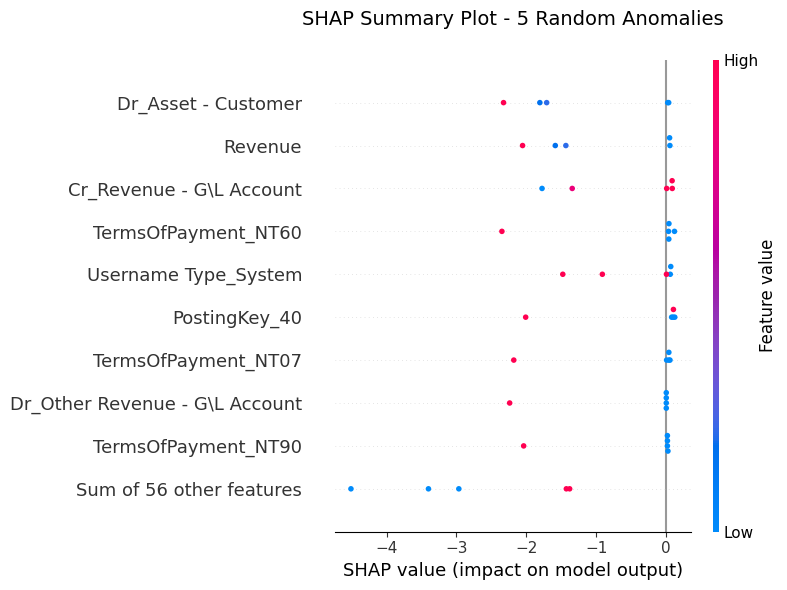

In [60]:
# Create SHAP Explanation object
expl_random = shap.Explanation(
    values=shap_values_random,
    data=X_random.values,
    feature_names=X_random.columns,
    instance_names=instance_names,
    base_values=expected_value
)

# --- Beeswarm Summary Plot ---
plt.figure(figsize=(8, 6))
shap.plots.beeswarm(
    expl_random,
    plot_size=None,
    show=False
)
plt.title("SHAP Summary Plot - 5 Random Anomalies", fontsize=14, pad=25)
plt.tight_layout()
plt.show()

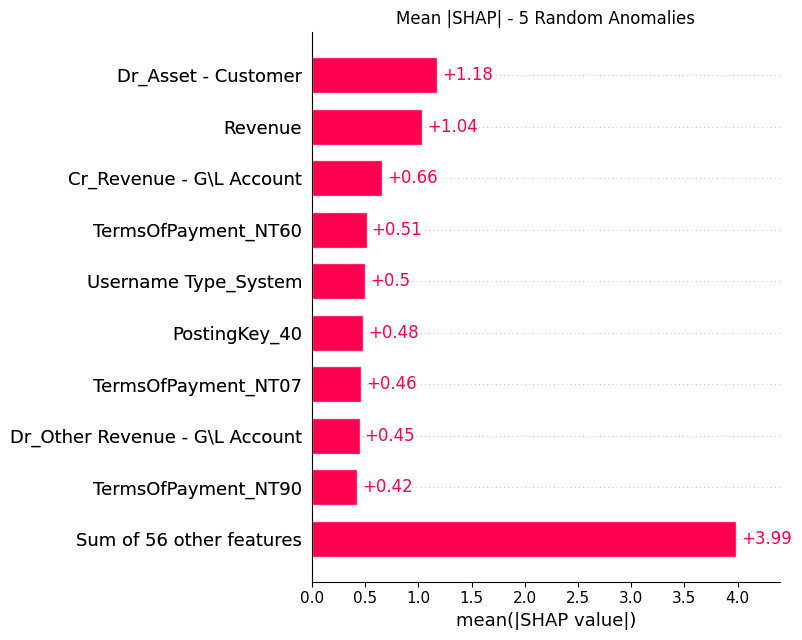

In [61]:
plt.figure(figsize=(8, 6))
shap.plots.bar(expl_random, show=False)
plt.title("Mean |SHAP| - 5 Random Anomalies")
plt.tight_layout()
plt.show()

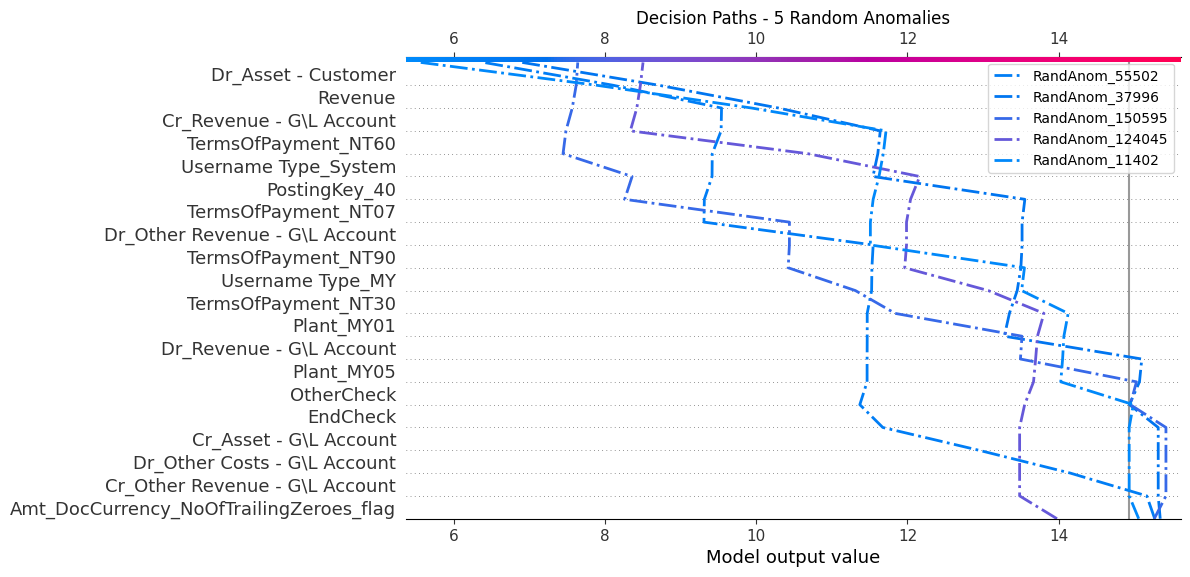

In [62]:
shap.decision_plot(
    expected_value,
    shap_values_random,
    X_random,
    link='identity',
    feature_order='importance',
    highlight=np.arange(len(shap_values_random)),
    legend_labels=instance_names,
    title="Decision Paths - 5 Random Anomalies",
    show=False
)
plt.gcf().set_size_inches(10, 6)
plt.show()

#### 2 groups (K + Manual)

In [ ]:
def run_isolation_forest_by_group(input_df, group_col, contamination='auto', compute_shap=False):
    results = []
    models = {}  # To store trained models per group
    shap_explanations = {}  # To store SHAP values per group (if requested)
    input_df_filled = input_df.copy()

    # Loop over each group
    input_df_filled[group_col] = input_df_filled[group_col].fillna('NAN')  # or any placeholder
    for group_name, group_data in input_df_filled.groupby(group_col):  #, dropna=False
        # print(f"\nRunning Isolation Forest on cluster/group: {group_name}")
        
        # Keep original index for mapping back
        original_index = group_data.index

        # Extract feature matrix
        X_in = group_data.drop(columns=[group_col], errors='ignore')

        # Scale features (recommended for better performance)
        # scaler = StandardScaler()
        # X_scaled = scaler.fit_transform(X)

        # Train Isolation Forest
        iso_forest = IsolationForest(
            n_estimators=50,             # default = 100
            max_features=1.0,
            max_samples='auto',
            contamination=contamination,
            random_state=42,
        )

        # iso_forest.fit(X_scaled)
        iso_forest.fit(X_in)

        # Predict anomaly scores and labels
        anomaly_scores = iso_forest.score_samples(X_in)    # Returns the raw anomaly score (log of average path length).
        predictions = iso_forest.predict(X_in)  # -1 = anomaly, 1 = normal

        # Count anomalies in this group
        num_anomalies = sum(predictions == -1)
        print(f"Cluster {group_name}: {num_anomalies} anomalies")

        # Add predictions to group_data
        group_result = pd.DataFrame({
            'anomaly_score': anomaly_scores,
            'is_anomaly': (predictions==-1),
            # 'is_anomaly_flag': (predictions == -1)
        }, index=original_index)

        # Append processed group
        results.append(group_result)
        models[group_name] = iso_forest  # Save model

        # 🔍 Compute SHAP values if requested
        if compute_shap:
            # Use TreeExplainer on the Isolation Forest
            explainer = shap.TreeExplainer(
                iso_forest,
                # feature_perturbation="interventional",  # or "tree_path_dependent"
                feature_perturbation="auto",  # or "tree_path_dependent"
                model_output='raw'  # score_samples output
            )
            shap_values = explainer.shap_values(X_in)
            shap_explanations[group_name] = {
                'shap_values': shap_values,
                'data': X_in,
                'explainer': explainer
            }

    # Concatenate all processed groups back into one DataFrame
    final_df = pd.concat(results)

    # # Ensure we preserve original order using original index
    final_df = final_df.reindex(input_df.index)

    if compute_shap:
        return final_df, models, shap_explanations
    else:
        return final_df

In [ ]:
df_with_anomalies_1, models, shap_explanations_1 = run_isolation_forest_by_group(df_manual, group_col='Cluster_ID', contamination=0.01, compute_shap=True)
df_with_anomalies_2, models, shap_explanations_2 = run_isolation_forest_by_group(df_k_means, group_col='K_cluster', contamination=0.01, compute_shap=True)

##### For each group

In [ ]:
def analyze_group_shap(shap_explanations, df_with_anomalies, group_name, dataset_label="Dataset"):
    """
    Analyze SHAP results for a given group from either shap_explanations_1 or shap_explanations_2.
    
    Parameters:
    - shap_explanations: shap_explanations_1 or shap_explanations_2
    - df_with_anomalies: the result DataFrame from run_isolation_forest_by_group
    - group_name: the group/cluster ID to analyze (e.g., 15, 'K1', etc.)
    - dataset_label: label for title (e.g., "Manual Clusters", "K-Means")
    """
    if group_name not in shap_explanations:
        print(f"❌ Group '{group_name}' not found in {dataset_label}.")
        print(f"Available groups: {list(shap_explanations.keys())}")
        return

    print(f"\n🔍 Analyzing Group '{group_name}' from {dataset_label}...")

    shap_info = shap_explanations[group_name]
    shap_values = shap_info['shap_values']
    X_data = shap_info['data']
    expected_value = shap_info['explainer'].expected_value

    # --- 1. SHAP Summary Plot (Beeswarm) ---
    plt.figure(figsize=(8, 6))
    shap.summary_plot(shap_values, X_data, show=False)
    plt.title(f"SHAP Summary - Group '{group_name}'\n({dataset_label})", fontsize=12)
    plt.tight_layout()
    plt.show()

    # --- 2. Force Plot for First Anomaly in This Group ---
    # Find anomalies in this group
    anomaly_mask = df_with_anomalies.loc[X_data.index, 'is_anomaly']
    
    if any(anomaly_mask):
        first_anomaly_idx = X_data[anomaly_mask].index[0]
        idx_in_group = X_data.index.get_loc(first_anomaly_idx)

        print(f"✅ First anomaly sample: {first_anomaly_idx}")
        print(f"Force Plot - Most Anomalous Sample in Group '{group_name}' ({dataset_label})")
        # Generate force plot
        force_plot = shap.force_plot(
            expected_value,
            shap_values[idx_in_group],
            X_data.loc[first_anomaly_idx],
            matplotlib=True,
            feature_names=X_data.columns.tolist()
        )
        # Note: matplotlib=True uses matplotlib backend (static); set to False for interactive
        
        plt.show()
    else:
        print(f"🟡 No anomalies detected in Group '{group_name}'.")

In [ ]:
# --- Usage Examples ---

# 🔹 Analyze group 15 in manual clusters
analyze_group_shap(
    shap_explanations=shap_explanations_1,
    df_with_anomalies=df_with_anomalies_1,  # note: ensure this matches the correct run if reused
    group_name=15,
    dataset_label="Manual Clusters"
)

In [ ]:
# 🔹 Analyze group 'K3' or 3 in K-means clusters
analyze_group_shap(
    shap_explanations=shap_explanations_2,
    df_with_anomalies=df_with_anomalies_2,  # same or different result df
    group_name=0.0,  # or 'K3' depending on your K_cluster values
    dataset_label="K-Means Clusters"
)

##### Overall pop

In [ ]:
# Initialize lists
all_shap_values = []
all_features = []

# Process Manual Clusters (df_manual)
print(f"Processing shap_explanations_1 (Manual Clusters)...")
for group_name, shap_info in shap_explanations_1.items():
    shap_vals = shap_info['shap_values']   # (n_samples_in_group, n_features)
    X_data = shap_info['data']             # (n_samples_in_group, n_features)
    
    all_shap_values.append(shap_vals)
    all_features.append(X_data)

# Process K-Means Clusters (df_k_means)
print(f"Processing shap_explanations_2 (K-Means Clusters)...")
for group_name, shap_info in shap_explanations_2.items():
    shap_vals = shap_info['shap_values']
    X_data = shap_info['data']
    
    all_shap_values.append(shap_vals)
    all_features.append(X_data)

# --- Combine all SHAP values and feature data ---
print("Combining SHAP values and features...")
combined_shap = np.concatenate(all_shap_values)   # Stacked SHAP values
combined_data = pd.concat(all_features, axis=0)   # Concatenate rows

# Optional: Ensure no index duplication (should be fine since disjoint)
assert combined_data.index.duplicated().sum() == 0, "Duplicate indices found!"

print(f"Total samples in combined SHAP analysis: {len(combined_data)}")

# --- Global SHAP Summary Plot (Beeswarm) ---
plt.figure(figsize=(10, 8))
shap.summary_plot(
    combined_shap,
    combined_data,
    plot_type="dot",  # default beeswarm
    show=False
)
plt.title("SHAP Beeswarm Plot - All Samples\n(Manual + K-Means Clusters)", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

## Using LIME<br>
Lime weight negative, Anomaly score lower -> more anomalous<br>
Higher -> more normal

### Functions

In [63]:
import lime
import lime.lime_tabular

def run_isolation_forest_by_group_lime(input_df, group_col, contamination='auto', compute_lime=False):
    results = []
    models = {}  # To store trained models per group
    lime_explanations = {}  # To store LIME explanations per group (if requested)
    input_df_filled = input_df.copy()

    # Fill NA in group column
    input_df_filled[group_col] = input_df_filled[group_col].fillna('NAN')

    # Loop over each group
    for group_name, group_data in input_df_filled.groupby(group_col):
        print(f"\nRunning Isolation Forest on cluster/group: {group_name}")

        original_index = group_data.index
        X_in = group_data.drop(columns=[group_col], errors='ignore')

        # Train Isolation Forest
        iso_forest = IsolationForest(
            n_estimators=50,
            max_features=1.0,
            max_samples='auto',
            contamination=contamination,
            random_state=42,
        )
        iso_forest.fit(X_in)

        # Predict anomaly scores and labels
        anomaly_scores = iso_forest.score_samples(X_in)
        predictions = iso_forest.predict(X_in)  # -1 = anomaly, 1 = normal

        num_anomalies = sum(predictions == -1)
        print(f"Cluster {group_name}: {num_anomalies} anomalies")

        # Add results
        group_result = pd.DataFrame({
            'anomaly_score': anomaly_scores,
            'is_anomaly': (predictions == -1)
        }, index=original_index)

        results.append(group_result)
        models[group_name] = iso_forest  # Save model

        # 🔍 Compute LIME explanations if requested
        if compute_lime and num_anomalies > 0:
            # Find an anomalous instance to explain
            anomaly_mask = predictions == -1
            anomaly_indices = np.where(anomaly_mask)[0]
            if len(anomaly_indices) > 0:
                # Pick first anomaly
                idx_to_explain = anomaly_indices[0]
                instance_to_explain = X_in.iloc[[idx_to_explain]]  # Keep DataFrame format

                # Prepare LIME explainer
                explainer = lime.lime_tabular.LimeTabularExplainer(
                    training_data=X_in.values,
                    feature_names=X_in.columns.tolist(),
                    class_names=['anomaly_score'],
                    mode='regression',
                    random_state=42,
                    verbose=True
                )

                # Define prediction function that returns a scalar score
                def prediction_fn(x):
                    # x is a numpy array of shape (n_samples, n_features)
                    df = pd.DataFrame(x, columns=X_in.columns)
                    scores = iso_forest.score_samples(df)
                    return scores  # Return raw anomaly scores

                # Generate explanation
                exp = explainer.explain_instance(
                    data_row=instance_to_explain.values[0],
                    predict_fn=prediction_fn,
                    num_features=X_in.shape[1]
                )

                # Store explanation
                lime_explanations[group_name] = {
                    'explanation': exp,
                    'instance': instance_to_explain,
                    'anomaly_score': anomaly_scores[idx_to_explain]
                }

                # Optional: show in notebook
                # exp.show_in_notebook()

    # Concatenate all results
    final_df = pd.concat(results)
    final_df = final_df.reindex(input_df.index)

    # Return based on LIME flag
    if compute_lime:
        return final_df, models, lime_explanations
    else:
        return final_df

In [64]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_lime_explanations(lime_explanations, max_features=10, show_plot=True):
    """
    Visualize LIME explanations from the output of run_isolation_forest_by_group_lime.
    
    Parameters:
        lime_explanations (dict): Dictionary of LIME results per group (from function output)
        max_features (int): Max number of top features to show per explanation
        show_plot (bool): Whether to call plt.show() (set False if using in loops)
    """
    num_groups = len(lime_explanations)
    
    if num_groups == 0:
        print("No LIME explanations to visualize.")
        return
    
    # Determine subplot layout
    cols = 2
    rows = (num_groups + 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))
    if rows == 1:
        axes = np.array([axes]) if cols > 1 else np.array([[axes]])
    axes = axes.flatten()

    for idx, (group_name, lime_data) in enumerate(lime_explanations.items()):
        exp = lime_data['explanation']
        instance = lime_data['instance']
        score = lime_data['anomaly_score']

        # Extract LIME explanation as list of (feature, weight)
        exp_list = exp.as_list()

        # Sort by absolute importance to show most impactful features first
        exp_list.sort(key=lambda x: abs(x[1]), reverse=True)
        exp_list = exp_list[:max_features]

        features, weights = zip(*exp_list)

        colors = ['red' if w < 0 else 'green' for w in weights]  # Red = increases anomaly, Green = reduces
        # Note: In LIME for regression, negative weight means feature reduces the score (less anomalous), 
        # positive means increases anomaly score (more anomalous)

        ax = axes[idx]
        ax.barh(features, weights, color=colors)
        ax.set_title(f"Group: {group_name}\nAnomaly Score: {score:.3f}")
        ax.set_xlabel("Contribution to Anomaly Score")
        ax.invert_yaxis()  # Highest importance on top

    # Hide unused subplots
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    if show_plot:
        plt.show()

### 1 cluster group (K_cluster)

In [65]:
df_with_anomalies, models, lime_explanations = run_isolation_forest_by_group_lime(df_num, group_col='K_cluster', compute_lime=True)


Running Isolation Forest on cluster/group: 0
Cluster 0: 3944 anomalies
Intercept -1.1939281752393422
Prediction_local [-0.65085136]
Right: -0.6720386275459456

Running Isolation Forest on cluster/group: 1
Cluster 1: 754 anomalies
Intercept -1.203170547671605
Prediction_local [-0.48736714]
Right: -0.5150117873702035

Running Isolation Forest on cluster/group: 2
Cluster 2: 1561 anomalies
Intercept -0.8730131508653014
Prediction_local [-0.52462617]
Right: -0.5107575002903039

Running Isolation Forest on cluster/group: 3
Cluster 3: 517 anomalies
Intercept -1.1898817141072664
Prediction_local [-0.59125876]
Right: -0.5061336924532902

Running Isolation Forest on cluster/group: 4
Cluster 4: 332 anomalies
Intercept -0.997808976061932
Prediction_local [-0.56696833]
Right: -0.515508657338699


In [66]:
lime_explanations[0.0]

{'explanation': <lime.explanation.Explanation at 0x23f93f61940>,
 'instance':       Cr_Asset - Asset  Cr_Asset - Customer  Cr_Asset - G\L Account  \
 1133               0.0                  0.0                     0.0   
 
       Cr_Asset - Material  Cr_Cost of Goods Sold (COGS) - G\L Account  \
 1133                  0.0                                         0.0   
 
       Cr_Expense (6) - G\L Account  Cr_Liability - G\L Account  \
 1133                           0.0                         0.0   
 
       Cr_Liability - Vendor  Cr_Other Costs - G\L Account  \
 1133                    0.0                           0.0   
 
       Cr_Other Revenue - G\L Account  ...  PaymentMethod_2  PaymentMethod_L  \
 1133                             0.0  ...                0                0   
 
       Document Type Description_Bill Doc.Tr - Cr Mem  \
 1133                                             1.0   
 
       Document Type Description_Bill Doc.Tr - Dr Mem  \
 1133                         

In [ ]:
data_22.groupby('TermsOfPayment')['AccDocNo'].

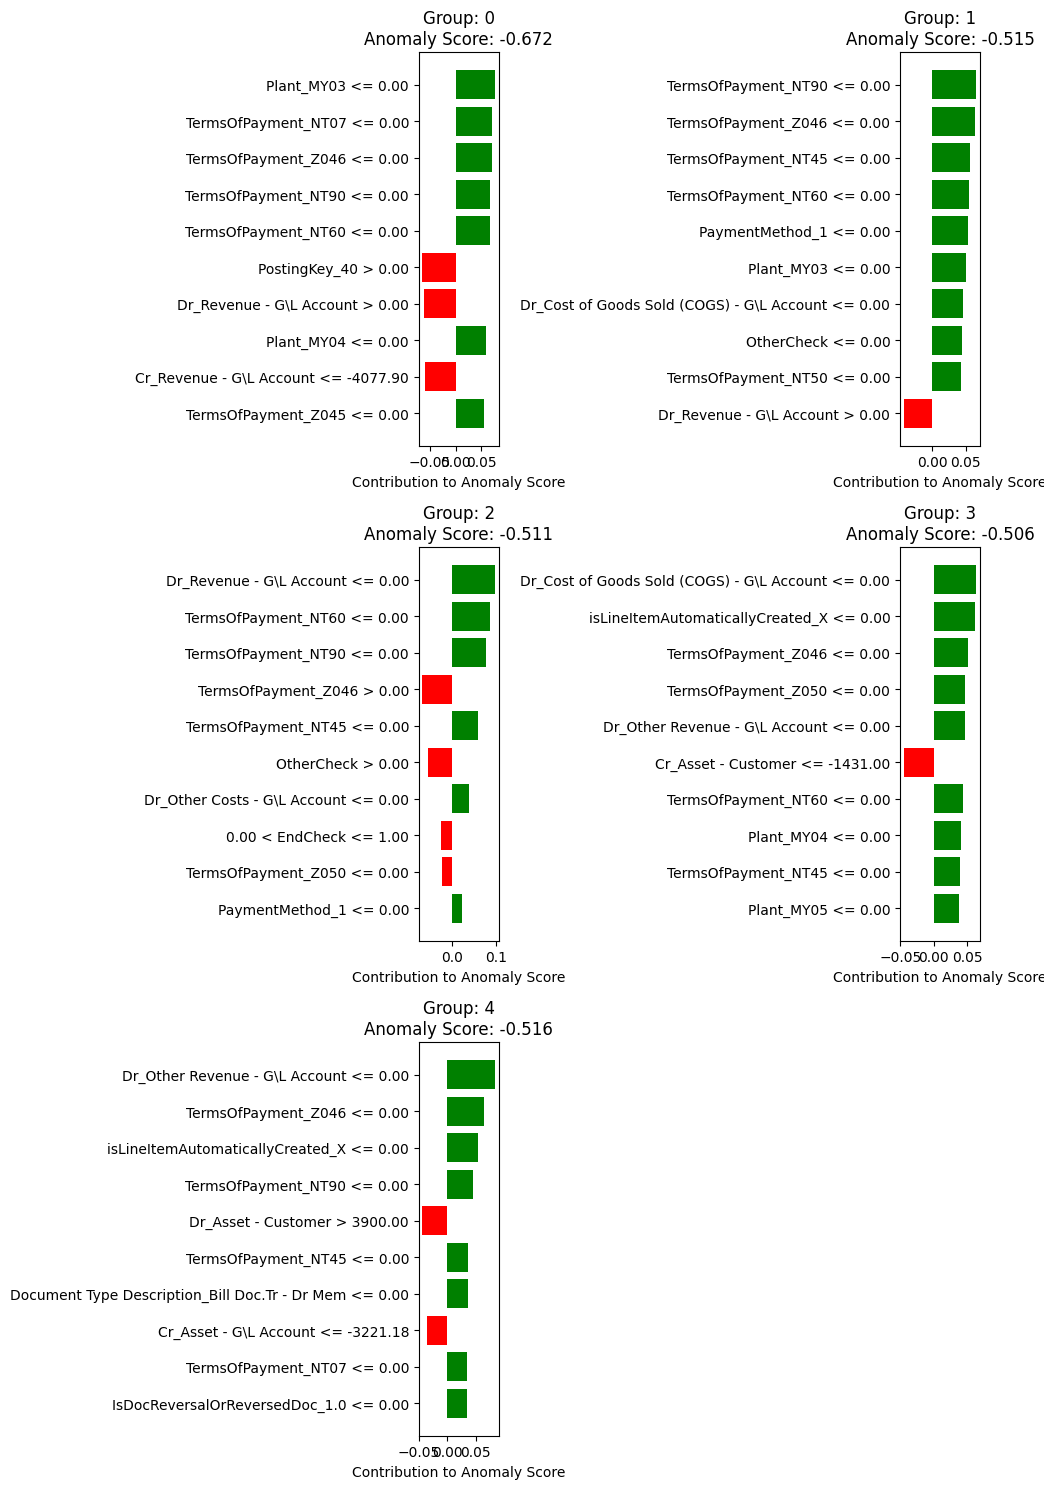

In [70]:
visualize_lime_explanations(lime_explanations, max_features=10)

### 2 cluster groups (Manual + K means)

In [ ]:
df_with_anomalies_1, models, lime_explanations_1 = run_isolation_forest_by_group_lime(df_manual, group_col='Cluster_ID', contamination=0.01, compute_lime=True)
df_with_anomalies_2, models, lime_explanations_2 = run_isolation_forest_by_group_lime(df_k_means, group_col='K_cluster', contamination=0.01, compute_lime=True)

In [ ]:
# View LIME explanation for a group
group_name = list(lime_explanations_1.keys())[0]
exp = lime_explanations_1[group_name]['explanation']
# exp.show_in_notebook()  # If in Jupyter
print(exp.as_list())

In [ ]:
# View LIME explanation for a group
group_name = list(lime_explanations_2.keys())[0]
exp = lime_explanations_2[group_name]['explanation']
# exp.show_in_notebook()  # If in Jupyter
print(exp.as_list())

In [ ]:
visualize_lime_explanations(lime_explanations_1, max_features=8)

In [ ]:
visualize_lime_explanations(lime_explanations_2, max_features=8)

## Using sd

In [ ]:
# Assume df_numeric is your DataFrame of numerical features

# Step 1: Get global statistics
feature_means = df_numeric.mean()
feature_stds = df_numeric.std()

# Step 2: Get anomalous rows
anomaly_indices = np.where(df_with_anomalies['is_anomaly'] == 1)[0]
anomalies = df_numeric.iloc[anomaly_indices].copy()

# Step 3: Compute z-scores (number of standard deviations from mean)
z_scores = (anomalies - feature_means) / feature_stds

# Take absolute z-scores to find largest deviations
abs_z_scores = z_scores.abs()

# Optional: Add the anomaly score for reference
abs_z_scores['anomaly_score'] = df_with_anomalies['anomaly_score'][anomaly_indices]

# Now, for each anomalous row, find the feature with the highest z-score
# This feature is the most "unusual" for that row
primary_culprit_per_row = abs_z_scores.drop(columns=['anomaly_score']).idxmax(axis=1)  # idxmax -> get max element
max_z_score_per_row = abs_z_scores.drop(columns=['anomaly_score']).max(axis=1)

# Add these to the summary
abs_z_scores['primary_culprit'] = primary_culprit_per_row
abs_z_scores['max_z_score'] = max_z_score_per_row

# Final result
print(abs_z_scores[['primary_culprit', 'max_z_score', 'anomaly_score']].head())

In [ ]:
abs_z_scores

# Save results

In [ ]:
table_name="anomaly_res_21m"

sql_db.fn_create_new_table_from_df(table_name=table_name, df=data_22_with_anomalies, auto_data_type=True)
res=sql_db.fn_append_df_to_table(table_name=table_name, df=data_22_with_anomalies)
print(res)

# 8 mins